In [1]:
#### kusto query public server

import pandas as pd
from azure.kusto.data import KustoClient, KustoConnectionStringBuilder, ClientRequestProperties
from azure.kusto.data.helpers import dataframe_from_result_table
from azure.kusto.data.exceptions import KustoServiceError
import traceback
import logging
import time

class KustoQuery(object):
    def __init__(self, **kwargs):        
        # self.client = None
        # self.kcsb = None
        # initialize client
        self.get_kusto_client()
        
    def get_kusto_client(self, **kwargs):
        import urllib3
        urllib3.disable_warnings()
    
        # self.cluster = kwargs.get('cluster', 'https://deepicm.westus2.kusto.windows.net')
        # self.cluster = 'https://msraaiops.eastus.kusto.windows.net'
        KustoCluster = 'https://cogsvc.kusto.windows.net/' #'https://msraaiops.eastus.kusto.windows.net'
        
        self.db = kwargs.get('database', 'Shared')#'WorkloadProfiling')
        self.db = 'Platform'
        # self.application_name = kwargs.get('application_name', "67862165-cbdc-4811-bb83-d6d945a98b6b")
        # self.AAD_tenant_id = kwargs.get('AAD_tenant_id', '72f988bf-86f1-41af-91ab-2d7cd011db47')     
   
        # self.application_name = kwargs.get('application_name', "549d2a15-4a98-4fee-becb-773e531b0f7c")
        # self.AAD_tenant_id = kwargs.get('AAD_tenant_id', '72f988bf-86f1-41af-91ab-2d7cd011db47')

        # ClientId = self.application_name
        # ClientSecret = self.application_pwd
        # AADTenantId = self.AAD_tenant_id
        
        # KustoCluster = self.cluster
        #kcsb = KustoConnectionStringBuilder.with_aad_device_authentication(KustoCluster) ### use this one to access via AAD
        kcsb = KustoConnectionStringBuilder.with_az_cli_authentication(KustoCluster)
        #kcsb = KustoConnectionStringBuilder.with_aad_application_key_authentication(KustoCluster, ClientId, ClientSecret, AADTenantId)
        kusto_client = KustoClient(kcsb)
        kusto_client._session.verify = False
        self.kcsb = kcsb
        self.client = kusto_client 
        
    def query(self, kql=None, return_type='dataframe'):
        if self.client is None:
            self.get_kusto_client()
        try:
            response = self.client.execute(self.db, kql)
            res = response.primary_results[0]
            if return_type == 'dataframe':
                return dataframe_from_result_table(res)
        except KustoServiceError as error:
            print("Error:",error)
            print('Retrying after sleeping for 10 sec..')
            #time.sleep(600)
            time.sleep(10)
            
            response = self.client.execute(self.db, kql)
            res = response.primary_results[0]
            if return_type == 'dataframe':
                return dataframe_from_result_table(res)
            else:
                return None
            # print("KustoServiceError: ", error)
            #logging.getLogger().warn(f'exception error = {error}, kql = {kql}')
            #logging.getLogger().warn(traceback.format_exc())
            #return None

In [27]:
query = """
let _startTime = datetime(2024-06-12T{start}:00:00Z);
let _endTime = datetime(2024-06-12T{end}:00:00Z);
let _percentile = int(95);
let EuLocations = dynamic(["francecentral","switzerlandwest","norwayeast","swedencentral","germanywestcentral","italynorth","francecentral","polandcentral","switzerlandnorth","westeurope"]);
let NamLocations = dynamic(["eastus2","westus3","canadaeast","northcentralus","canadacentral","westus2","westus","centralus","eastus","southcentralus",""]);
let RowLocations = dynamic(["australiaeast","southeastasia","uksouth"]);
let GovLocations = dynamic(["usgovarizona","usgovtexas"]);
//---------
let prodDeployments = cluster('modeldqasprodeus2.eastus').database('modeldqaseus2db').LLMApiRequestTracingEvent_Global
| where ResolvedModelName startswith "prod"
| distinct tolower(DeploymentName);
let GPT_O_benchmark = view () {{ print OperatingPoint = 2700, ModelName = "gpt-4o", ModelVersion = "2024-05-13T00:00:00.0000000Z" }};
let Benchmark_stored = cluster('inferencedashboardlog.westus2.kusto.windows.net').database('LLMAPI').ModelBenchmark
| extend OperatingPoint = TPS
| project OperatingPoint, ModelName, ModelVersion;
let Benchmark = union GPT_O_benchmark, Benchmark_stored;
let m365Deps = materialize(GetOpenAIDeployments(subscriptionId= "dbee6bb5-f1c3-4961-9fb4-d8865cb6b1ea", startTime=_startTime, duration=1h)
| where SkuName == "Provisioned"
| where DeloyName in~ (prodDeployments)
| extend endpointName = iff(Endpoint contains_cs ".", split(Endpoint, ".")[0], Endpoint)
| project endpointName, Model, Version, Location, DesignatedCapacity, SkuCapacity, Name);
let amlEndpoints = 
m365Deps | project endpointName;
let existingAmlDeployments = materialize(AoaiAmlDeploymentsSnapshot(_startTime)
| where AmlEndpointName  in (amlEndpoints)
| distinct AmlEndpointName, GpuType);
let CurrentGpus = materialize(m365Deps
| join kind=inner existingAmlDeployments on $left.endpointName == $right.AmlEndpointName
| join kind=inner Benchmark on $left.Model==$right.ModelName and $left.Version==$right.ModelVersion
| extend UserRegion = case(
     EuLocations has Location, "EU",
     NamLocations has Location, "NAM",
     "ROW"
    )
| extend efficiencyMultiplier = case (
    GpuType startswith "H100", 2.5,
    1.0)
| extend AdjustedDesignatedCapacity = efficiencyMultiplier * iff(isempty(DesignatedCapacity), SkuCapacity, DesignatedCapacity)
| project Model, Version, UserRegion, Location, OperatingPoint, Name, AdjustedDesignatedCapacity);
// --------
let peakUsageQuery=(_gpuPerInstance: int, ModelNameInBenchmark: string, ModelVersionInBenchmark:string, ModelNames:dynamic) {{
    let GpuForModel = CurrentGpus
        | where Model == ModelNameInBenchmark and Version == ModelVersionInBenchmark;
    let llmApiData = cluster('modeldqasprodeus2.eastus').database('modeldqaseus2db').LLMApiRequestTracingEvent_Global
        | where TIMESTAMP between(_startTime .. _endTime)
        | where ResolvedModelName in (ModelNames)
        | extend DeploymentRegion = tostring(split(DeploymentBaseUri,'/')[-1])
        | summarize SumOfTokens = sum(TotalTokenCountBucket) by bin(TIMESTAMP, 1s), Tenant, DeploymentRegion
        | project Tenant, SumOfTokens, TIMESTAMP, DeploymentRegion;
    GpuForModel | join kind=inner llmApiData on $left.Name == $right.DeploymentRegion
        | extend TenantRegion = tostring(split(Tenant,'-')[1])
        | extend OriginRegion = case(
            EuLocations has TenantRegion, "EU",
            NamLocations has TenantRegion, "NAM",
            "ROW")
        | summarize sum(SumOfTokens) by bin(TIMESTAMP, 1s), TenantRegion, OperatingPoint, Model
        | summarize PeakTPS = percentile(sum_SumOfTokens, _percentile) by bin(TIMESTAMP, 1h), TenantRegion, OperatingPoint, Model
        | extend TotalGPUs = (PeakTPS/OperatingPoint)*_gpuPerInstance
        | summarize MaxPeakGPUs = max(TotalGPUs) by TenantRegion, Model
}};
// -----------
let DV3 = peakUsageQuery(24,"dv3","2",dynamic(['prod-moonshot']));
let gpt4_0125 = peakUsageQuery(24,"gpt-4","0125-Preview",dynamic(['prod-gpt-4-0125', 'prod-gpt-4-0125-chat-completions']));
let gpt4_1106 = peakUsageQuery(24,"gpt-4","1106-Preview",dynamic(['prod-gpt-4-1106', 'prod-gpt-4-turbo', 'prod-gpt-4-1106-chat-completions', 'prod-gpt-4-turbo-chat-completions']));
let ppo = peakUsageQuery(24,"dv-ppo","2",dynamic(['prod-ppo']));
let gpt35_0125 = peakUsageQuery(8,"gpt-35-turbo","0125",dynamic(['prod-gpt-35-0125','prod-gpt-35-0125-chat-completions']));
let gpt35_0301 = peakUsageQuery(8,"gpt-35-turbo","0301",dynamic(['prod-gpt-35-turbo','prod-chat-completion-gpt-35-turbo']));
let gpt35_16k = peakUsageQuery(8,"gpt-35-turbo-16k","0613",dynamic(['prod-chat-completion-gpt-35-turbo-16k']));
let gpt_o = peakUsageQuery(8,"gpt-4o","2024-05-13T00:00:00.0000000Z",dynamic(['prod-gpt-4o-2024-05-13','prod-gpt-4o-2024-05-13-chat-completions']));
let PeakUsage = union DV3, ppo, gpt4_0125, gpt4_1106, gpt35_0125, gpt35_0301, gpt35_16k, gpt_o;
let _regions = dynamic(['eastus', 'eastus2', 'centralus', 'northcentralus', 'southcentralus', 'westcentralus', 'westus', 'westus2', 'westus3']);
CurrentGpus
| summarize PTUSum = sum(AdjustedDesignatedCapacity), GPUSum = (sum(AdjustedDesignatedCapacity)/100)*8 by Model, Location // For gpt 4 models, this will be the same as /300*24
// | join kind=leftouter PeakUsage on Model, $left.Location == $right.TenantRegion
| where Location in (_regions)
// | extend GpuDelta = GPUSum - MaxPeakGPUs
| extend  Model = tolower(replace_regex(Model, "-", ""))
// | project Model, Location, PTUSum, GPUSum, MaxPeakGPUs, GpuDelta // For gpt 4 models, this will be the same as /300*24
| order by Model, Location;
"""

In [28]:
dfa = pd.DataFrame(columns=['TIMESTAMP', 'Model', 'Location', 'PTUSum', 'GPUSum'])
for i in range(23):
    start = str(i).zfill(2)
    end = str(i+1).zfill(2)
    print(start, end)
    q = query.format(start=start, end=end)
    # print(q)
    kq = KustoQuery()
    df = kq.query(q)
    df['TIMESTAMP'] = pd.to_datetime(f'2024-06-12 {start}:00:00')
    dfa = pd.concat([dfa, df], ignore_index=True)

00 01


C:\Users\t-shjaiswal\AppData\Local\Temp\ipykernel_28928\3669173619.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfa = pd.concat([dfa, df], ignore_index=True)


01 02
02 03
03 04
04 05
05 06
06 07
07 08
08 09
09 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23


In [29]:
start = "23"
end = "00"
print(start, end)
q = query.format(start=start, end=end)
# print(q)
kq = KustoQuery()
df = kq.query(q)
df['TIMESTAMP'] = pd.to_datetime(f'2024-06-12 {start}:00:00')
dfa = pd.concat([dfa, df], ignore_index=True)

23 00


In [36]:
dfa['Location'].unique()

array(['westus3', 'westus2', 'eastus2', 'westus', 'centralus',
       'northcentralus', 'eastus'], dtype=object)

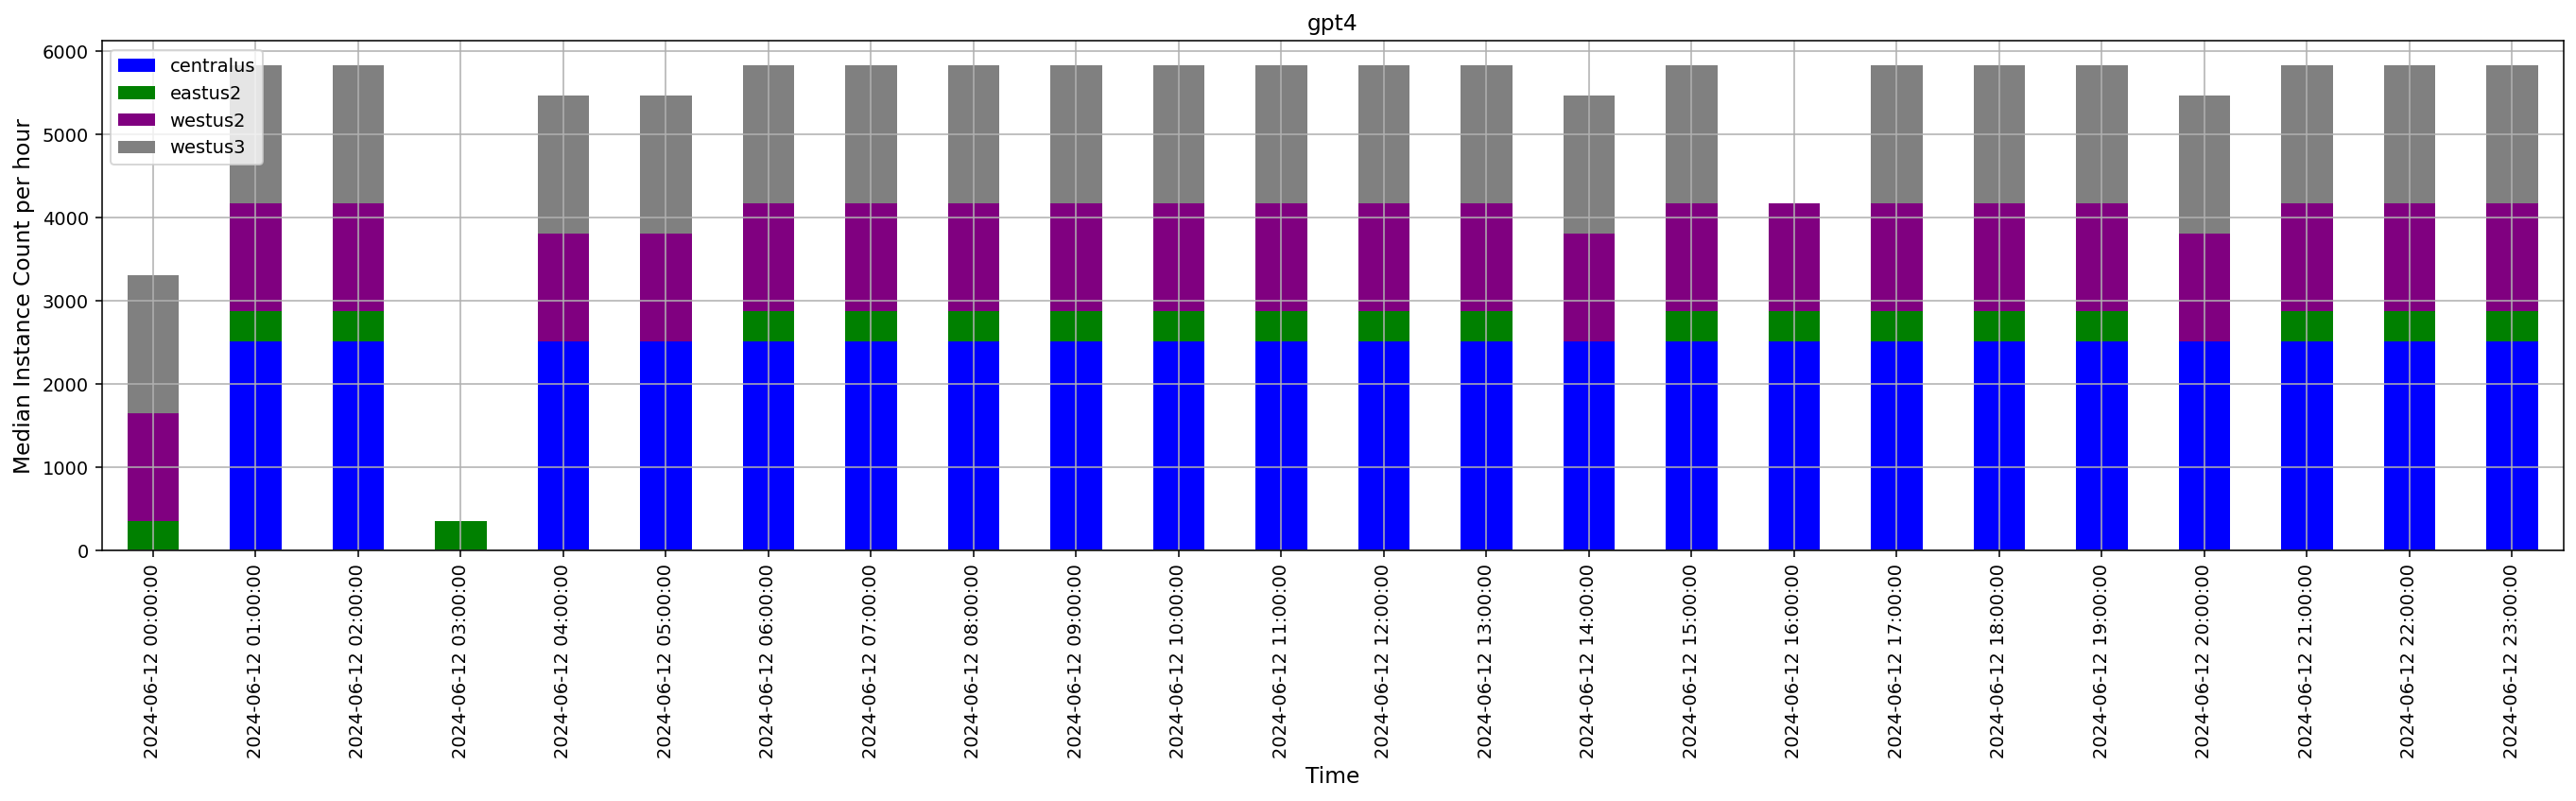

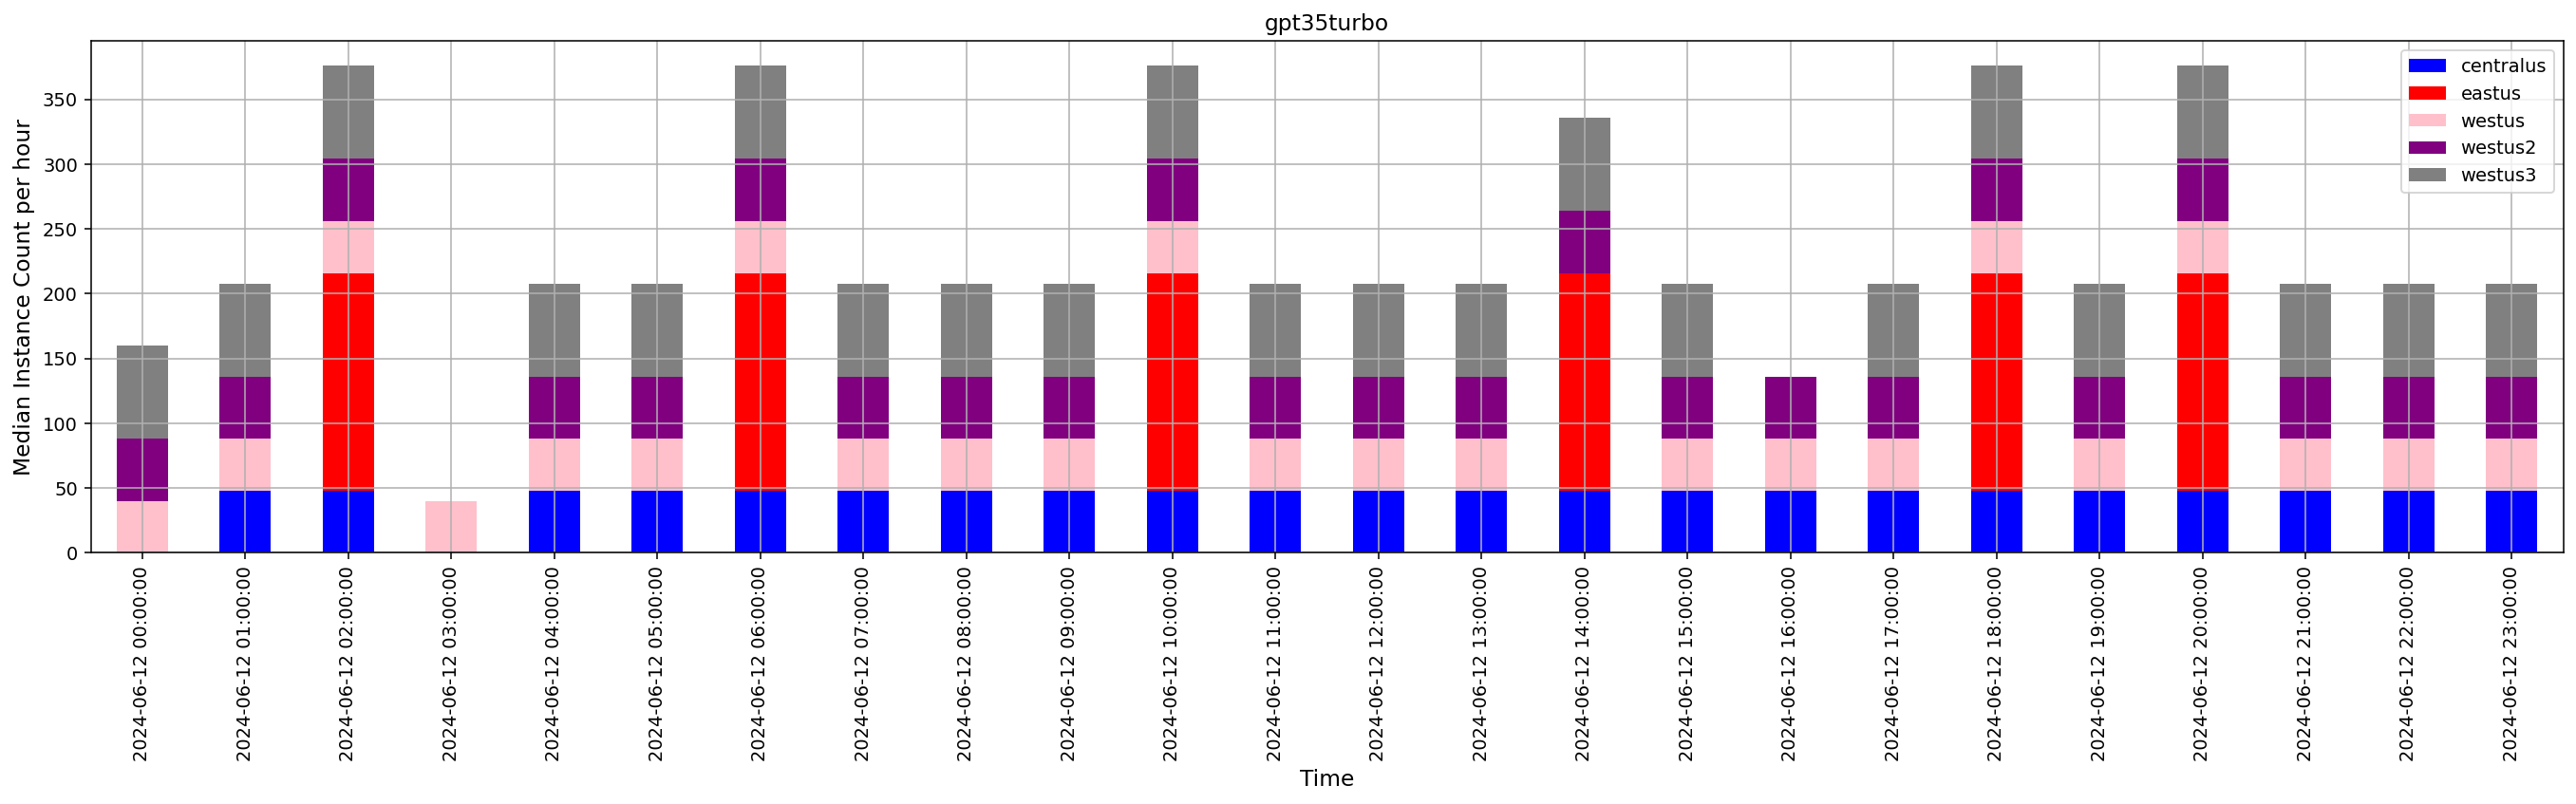

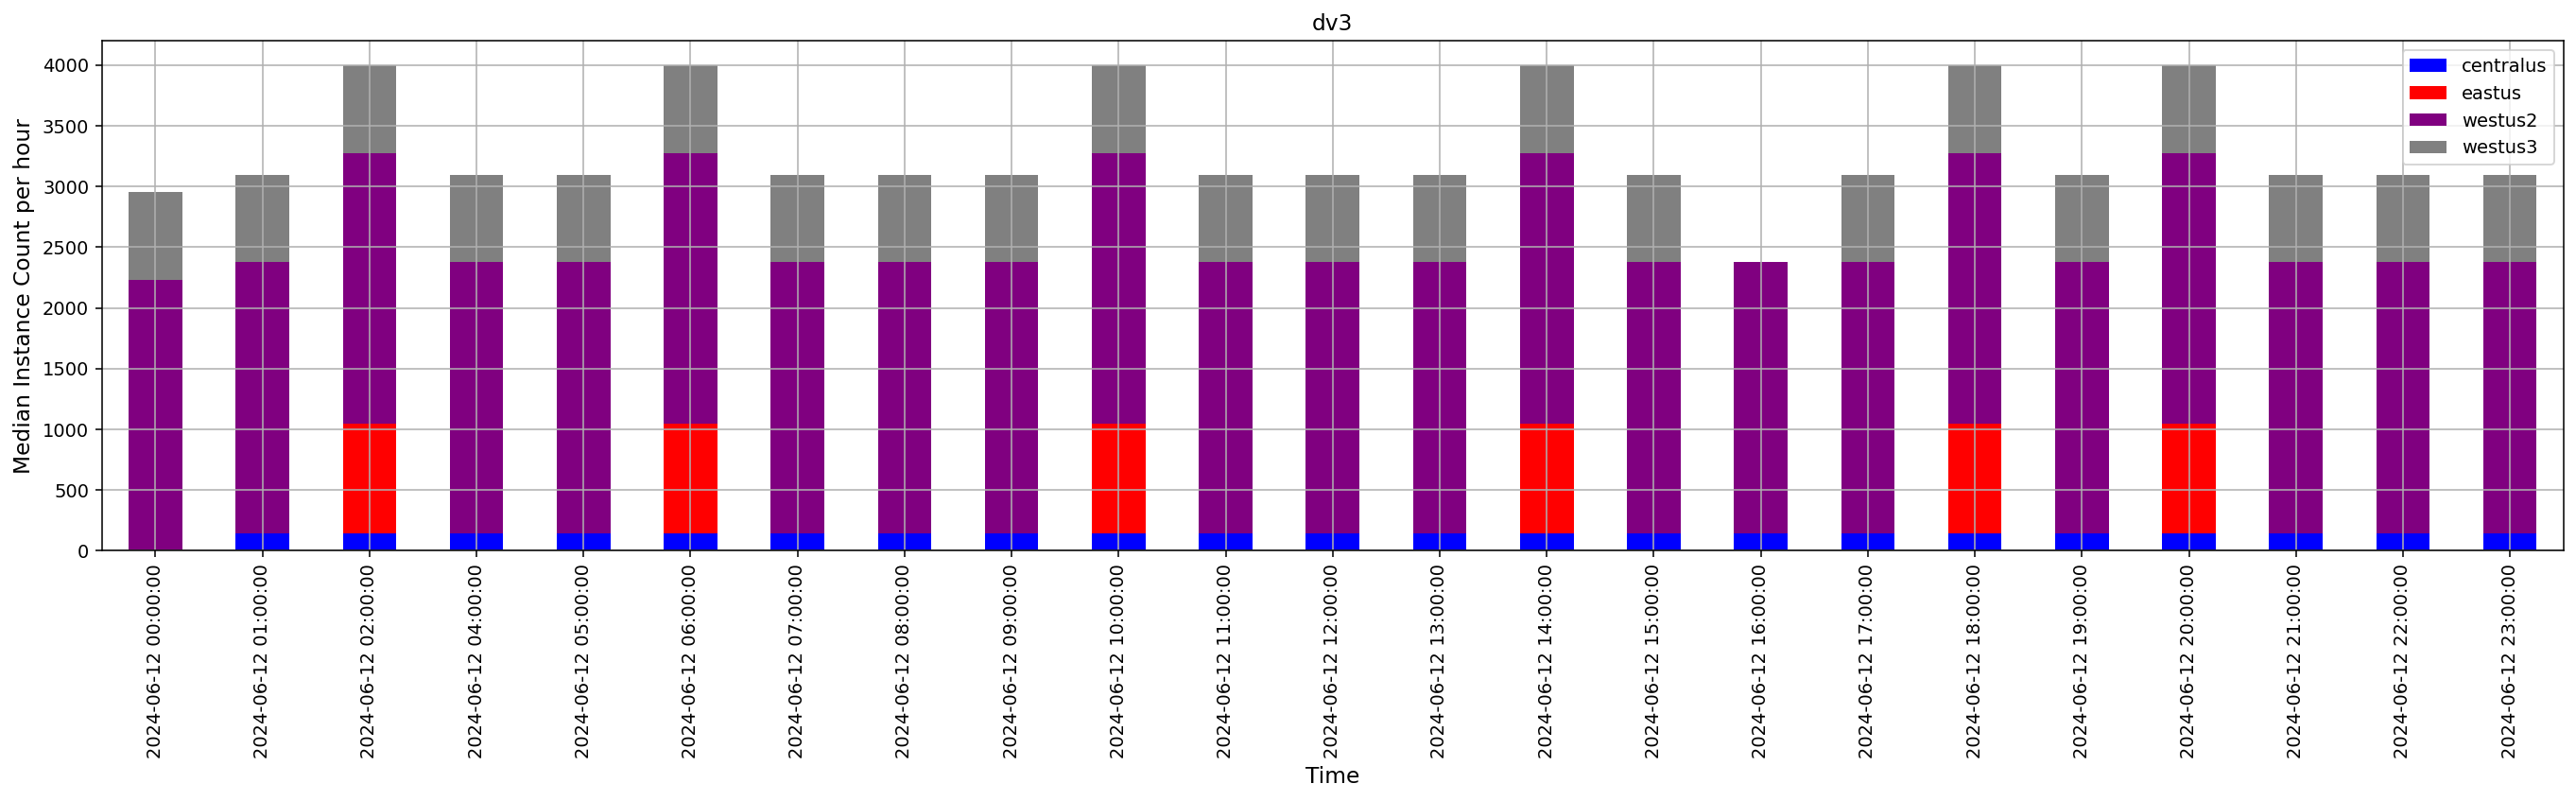

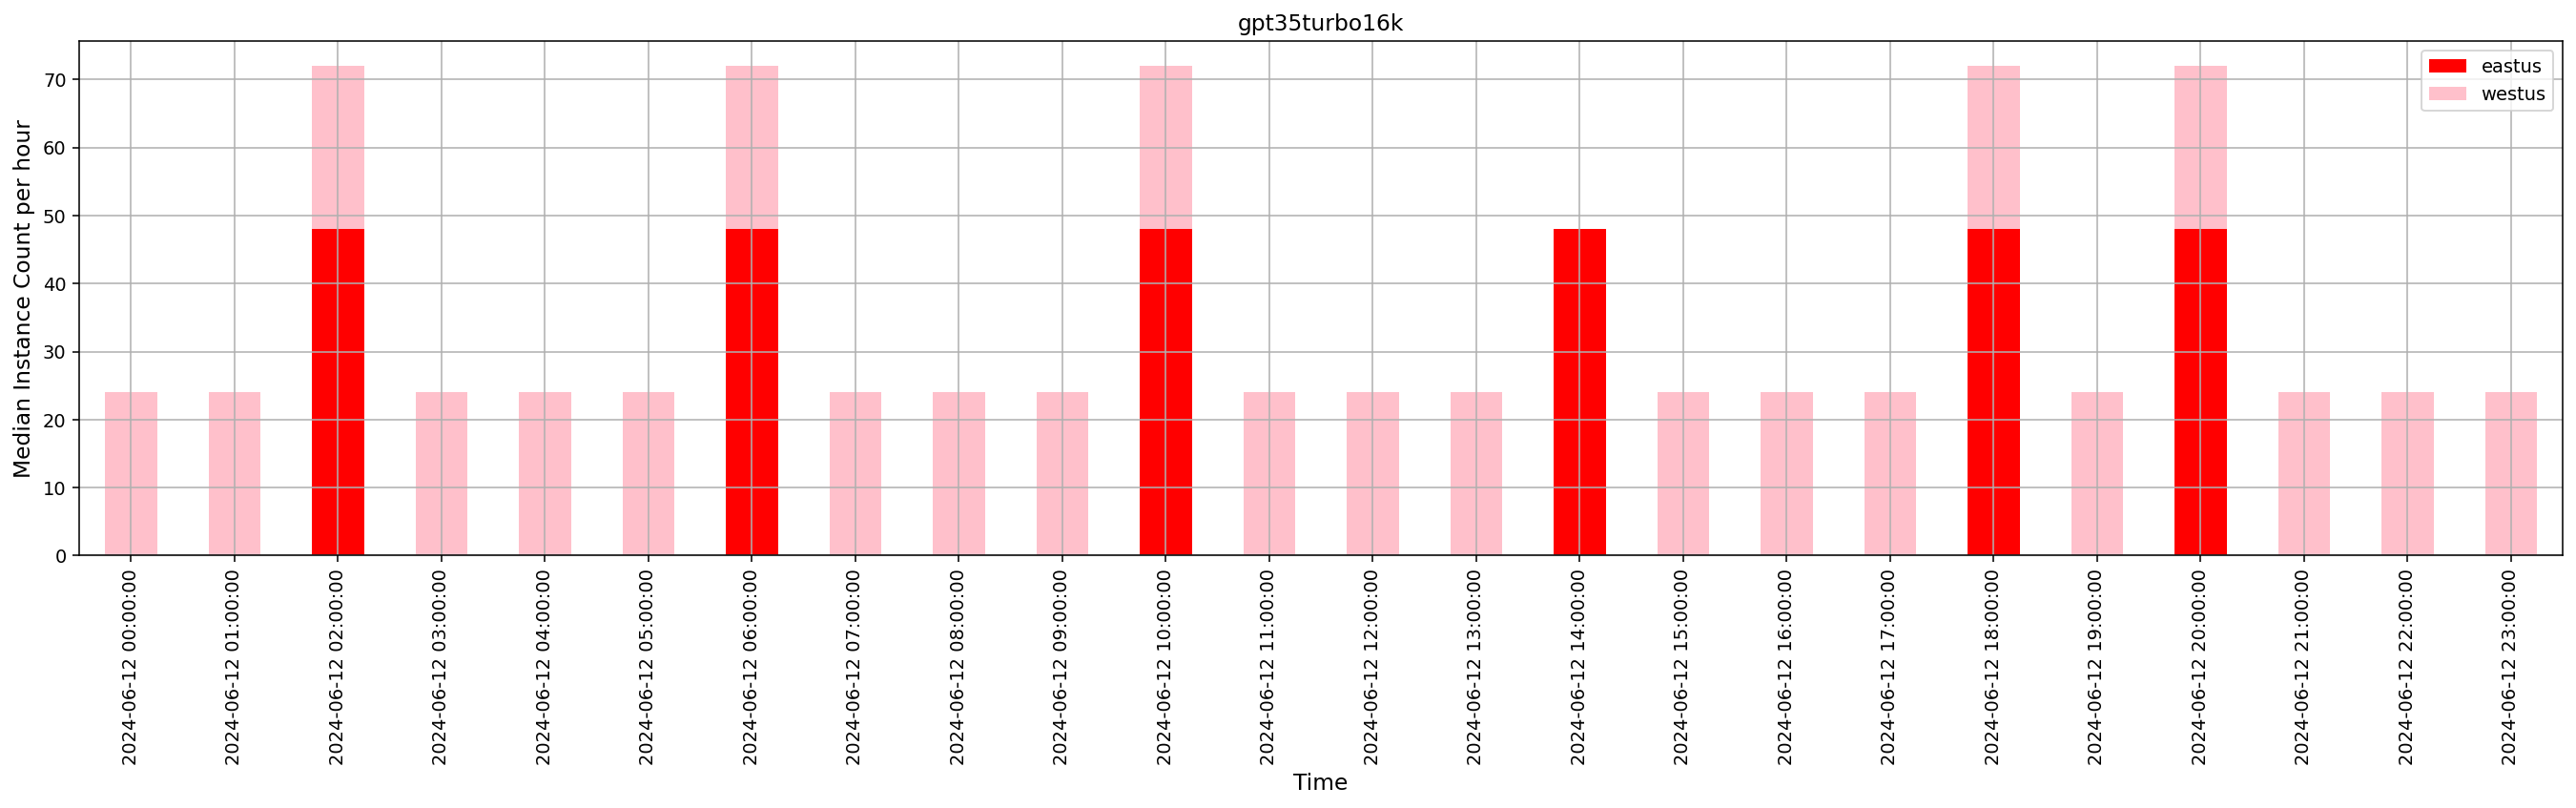

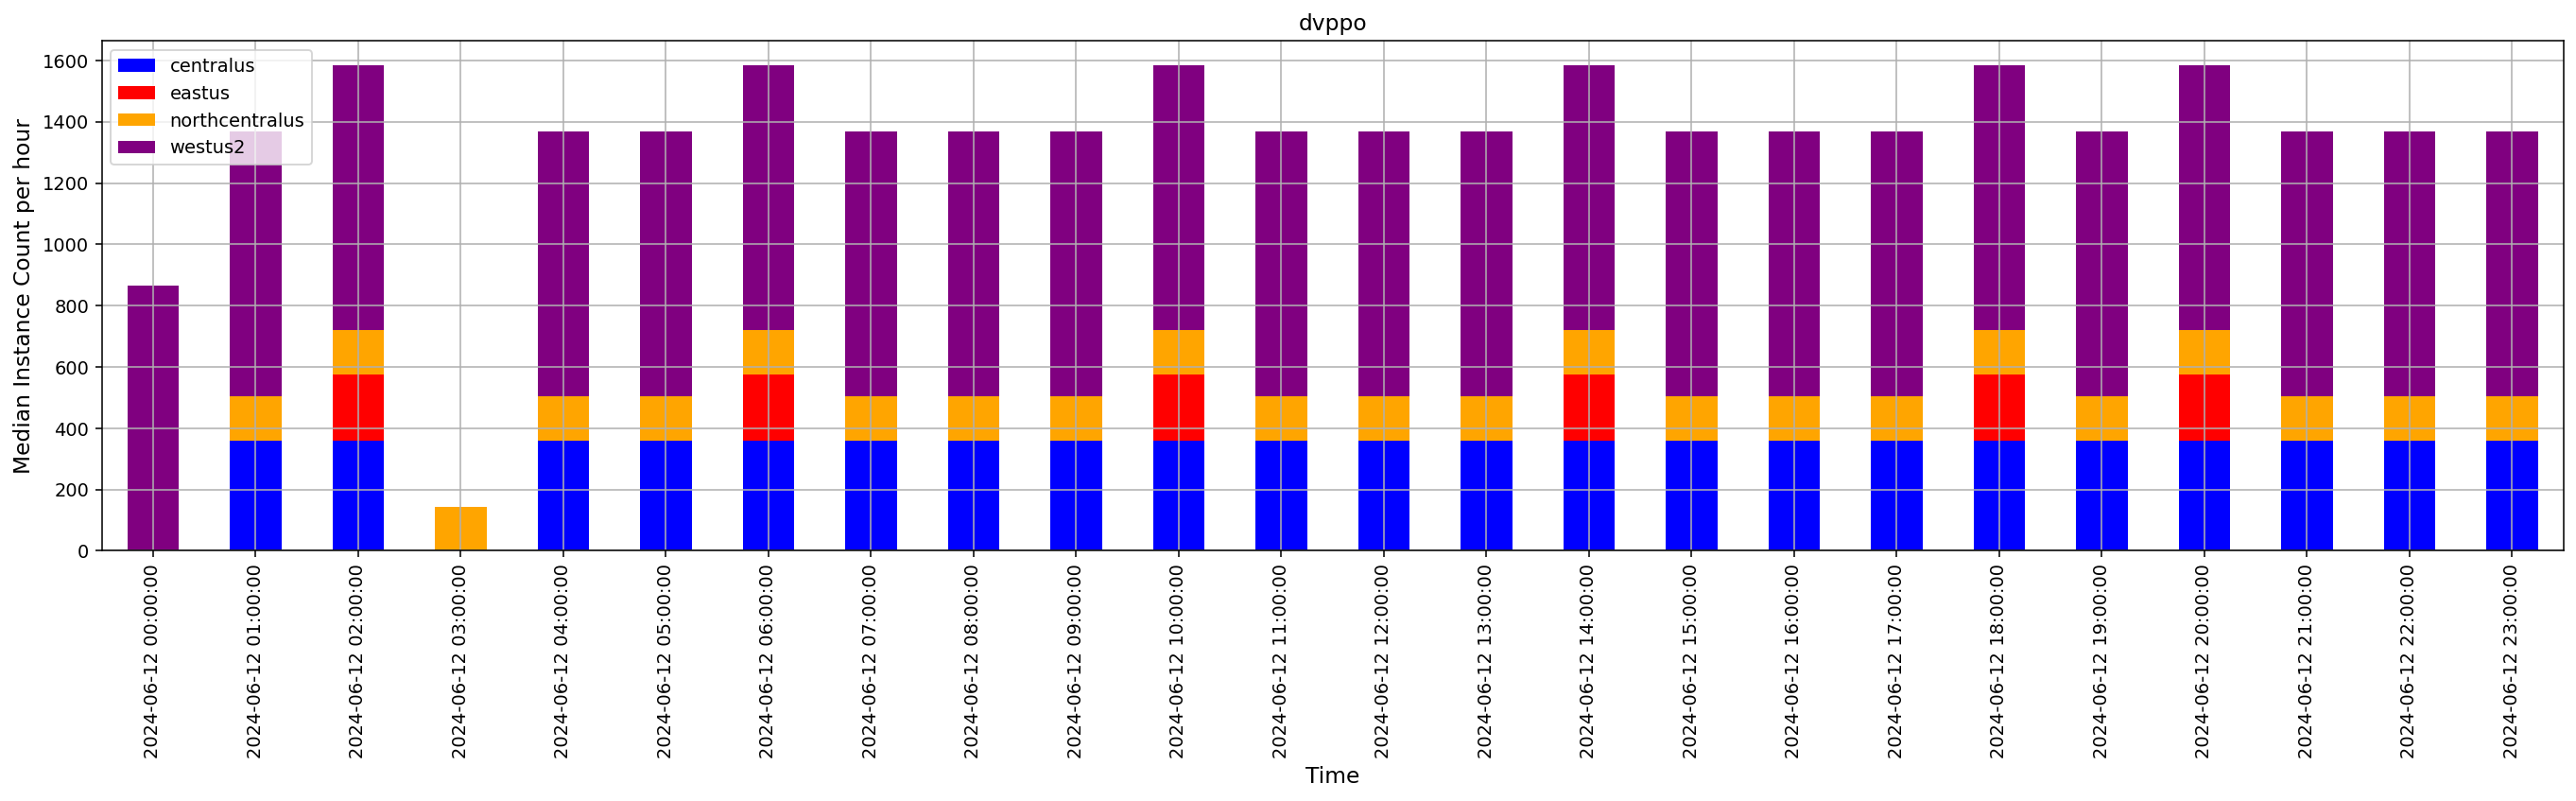

In [37]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 140
region_to_colors = {
    'centralus': 'blue',
    'eastus': 'red',
    'eastus2': 'green',
    'northcentralus': 'orange',
    'westus': 'pink',
    'westus2': 'purple',
    'westus3': 'grey'
}
for model_name in ['gpt4', 'gpt35turbo', 'dv3', 'gpt35turbo16k', 'dvppo']:
    filtered_df = dfa[dfa['Model'] == model_name]
    # Group the dataframe by TIMESTAMP and DeploymentRegion and sum the requestsCount
    grouped_df = filtered_df.groupby(['TIMESTAMP', 'Location'])['GPUSum'].sum().unstack()
    # print(res.groupby(['TIMESTAMP', 'DeploymentRegion'])['requestsCount'].sum().unstack())
    # plt.figure(figsize=(10, 5), dpi=150)
    # Plot the stacked barplot
    grouped_df = grouped_df.fillna(0)
    grouped_df.plot(kind='bar', stacked=True, figsize=(24, 5), color=[region_to_colors.get(region) for region in grouped_df.columns])
    # grouped_df.plot(kind='bar', stacked=True, figsize=(24, 5))

    # Set the x-axis label
    plt.xlabel('Time', fontsize=12)
    plt.title(f"{model_name}")
    # Set the y-axis label
    plt.ylabel('Median Instance Count per hour', fontsize=12)

    # Show the legend
    plt.legend()
    plt.grid()
    # Show the plot
    plt.show()

In [27]:
query = """
let _startTime = datetime({start});
let _regions = dynamic(['eastus', 'eastus2', 'centralus', 'northcentralus', 'southcentralus', 'westcentralus', 'westus', 'westus2', 'westus3']);
let _deploymentName = '';
ModelScaleSetStatus(_startTime)
| where parentResourceId has "dbee6bb5-f1c3-4961-9fb4-d8865cb6b1ea" 
| join kind=innerunique cluster('cogsvc.kusto.windows.net').database('platform').GetOpenAIDeployments(subscriptionId= "dbee6bb5-f1c3-4961-9fb4-d8865cb6b1ea", startTime=_startTime, duration=1h) 
on $left.deploymentInternalId == $right.InternalId
| where isempty(['_deploymentName']) or DeloyName in (['_deploymentName'])
| extend DonatedInstances = reservedInstanceCount - currentInstanceCount
| extend GPUsPerInstance = case(
Model == "dv3" or Model == "dv-ppo" or Model == "gpt-4" or Model == "gpt-4-32k", 24,
8
)
| summarize max(PreciseTimeStamp) by Location, DeloyName, Model, Version, parentResourceId, reservedInstanceCount, currentInstanceCount, DonatedInstances, GPUsPerInstance
| project-away max_PreciseTimeStamp
| summarize TotalInstanceCount = sum(reservedInstanceCount), CurrentInstanceCount = sum(currentInstanceCount), DonatedInstanceCount= sum(DonatedInstances), TotalGPUCount = sum(reservedInstanceCount*GPUsPerInstance), CurrentGPUCount = sum(currentInstanceCount*GPUsPerInstance), DonatedGPUCount = sum(DonatedInstances*GPUsPerInstance) by Model, Location
| where Location in (_regions)
| extend TIMESTAMP = _startTime
| extend Model = tolower(replace_regex(Model, "-", ""))
| order by Model, Location
"""

In [24]:
from datetime import datetime

datetime_string = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(datetime_string)

2024-07-11T17:55:17Z


In [44]:
from datetime import datetime

dfa = pd.DataFrame(columns=['TIMESTAMP', 'Model', 'Location', 'TotalInstanceCount', 'CurrentInstanceCount', 'DonatedInstanceCount', 'TotalGPUCount', 'CurrentGPUCount', 'DonatedGPUCount'])
startTime = datetime.fromisoformat('2024-06-23T00:00:00Z')
startTime += pd.DateOffset(hours=1)
for i in range(24*7):
    dt = startTime + pd.DateOffset(hours=i)
    print(dt.strftime("%Y-%m-%dT%H:%M:%SZ"))
    q = query.format(start=dt.strftime("%Y-%m-%dT%H:%M:%SZ"))
    kq = KustoQuery()
    df = kq.query(q)
    dfa = pd.concat([dfa, df], ignore_index=True)

2024-06-23T01:00:00Z


C:\Users\t-shjaiswal\AppData\Local\Temp\ipykernel_12332\328454129.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfa = pd.concat([dfa, df], ignore_index=True)


2024-06-23T02:00:00Z
2024-06-23T03:00:00Z
2024-06-23T04:00:00Z
2024-06-23T05:00:00Z
2024-06-23T06:00:00Z
2024-06-23T07:00:00Z
2024-06-23T08:00:00Z
2024-06-23T09:00:00Z
2024-06-23T10:00:00Z
2024-06-23T11:00:00Z
2024-06-23T12:00:00Z
2024-06-23T13:00:00Z
2024-06-23T14:00:00Z
2024-06-23T15:00:00Z
2024-06-23T16:00:00Z
2024-06-23T17:00:00Z
2024-06-23T18:00:00Z
2024-06-23T19:00:00Z
2024-06-23T20:00:00Z
2024-06-23T21:00:00Z
2024-06-23T22:00:00Z
2024-06-23T23:00:00Z
2024-06-24T00:00:00Z
2024-06-24T01:00:00Z
2024-06-24T02:00:00Z
2024-06-24T03:00:00Z
2024-06-24T04:00:00Z
2024-06-24T05:00:00Z
2024-06-24T06:00:00Z
2024-06-24T07:00:00Z
2024-06-24T08:00:00Z
2024-06-24T09:00:00Z
2024-06-24T10:00:00Z
2024-06-24T11:00:00Z
2024-06-24T12:00:00Z
2024-06-24T13:00:00Z
2024-06-24T14:00:00Z
2024-06-24T15:00:00Z
2024-06-24T16:00:00Z
2024-06-24T17:00:00Z
2024-06-24T18:00:00Z
2024-06-24T19:00:00Z
2024-06-24T20:00:00Z
2024-06-24T21:00:00Z
2024-06-24T22:00:00Z
2024-06-24T23:00:00Z
2024-06-25T00:00:00Z
2024-06-25T01

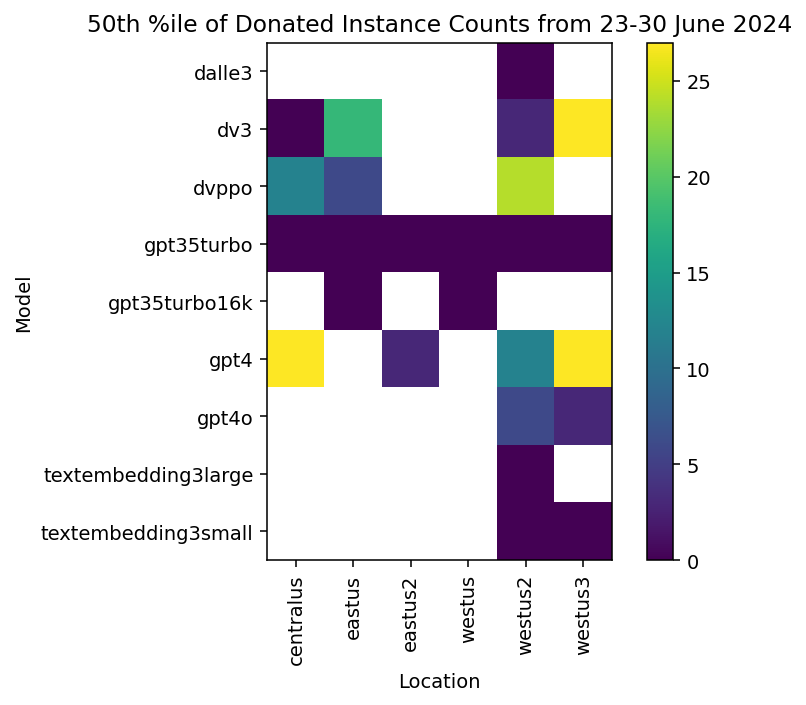

: 

In [46]:
import matplotlib.pyplot as plt

# Group the dataframe by Model and Location and calculate the median value
grouped_df = dfa.groupby(['Model', 'Location'])['DonatedInstanceCount'].quantile(0.5).unstack()

# Create the heatmap
plt.imshow(grouped_df.astype(float), cmap='viridis')  # Ensure grouped_df contains numeric data

# Set the x-axis and y-axis labels
plt.xlabel('Location')
plt.ylabel('Model')

# Set the x-axis and y-axis tick labels
plt.xticks(range(len(grouped_df.columns)), grouped_df.columns, rotation=90)
plt.yticks(range(len(grouped_df.index)), grouped_df.index)

# Show the colorbar
plt.colorbar()
plt.title('50th %ile of Donated Instance Counts from 23-30 June 2024')
# Show the plot
plt.show()

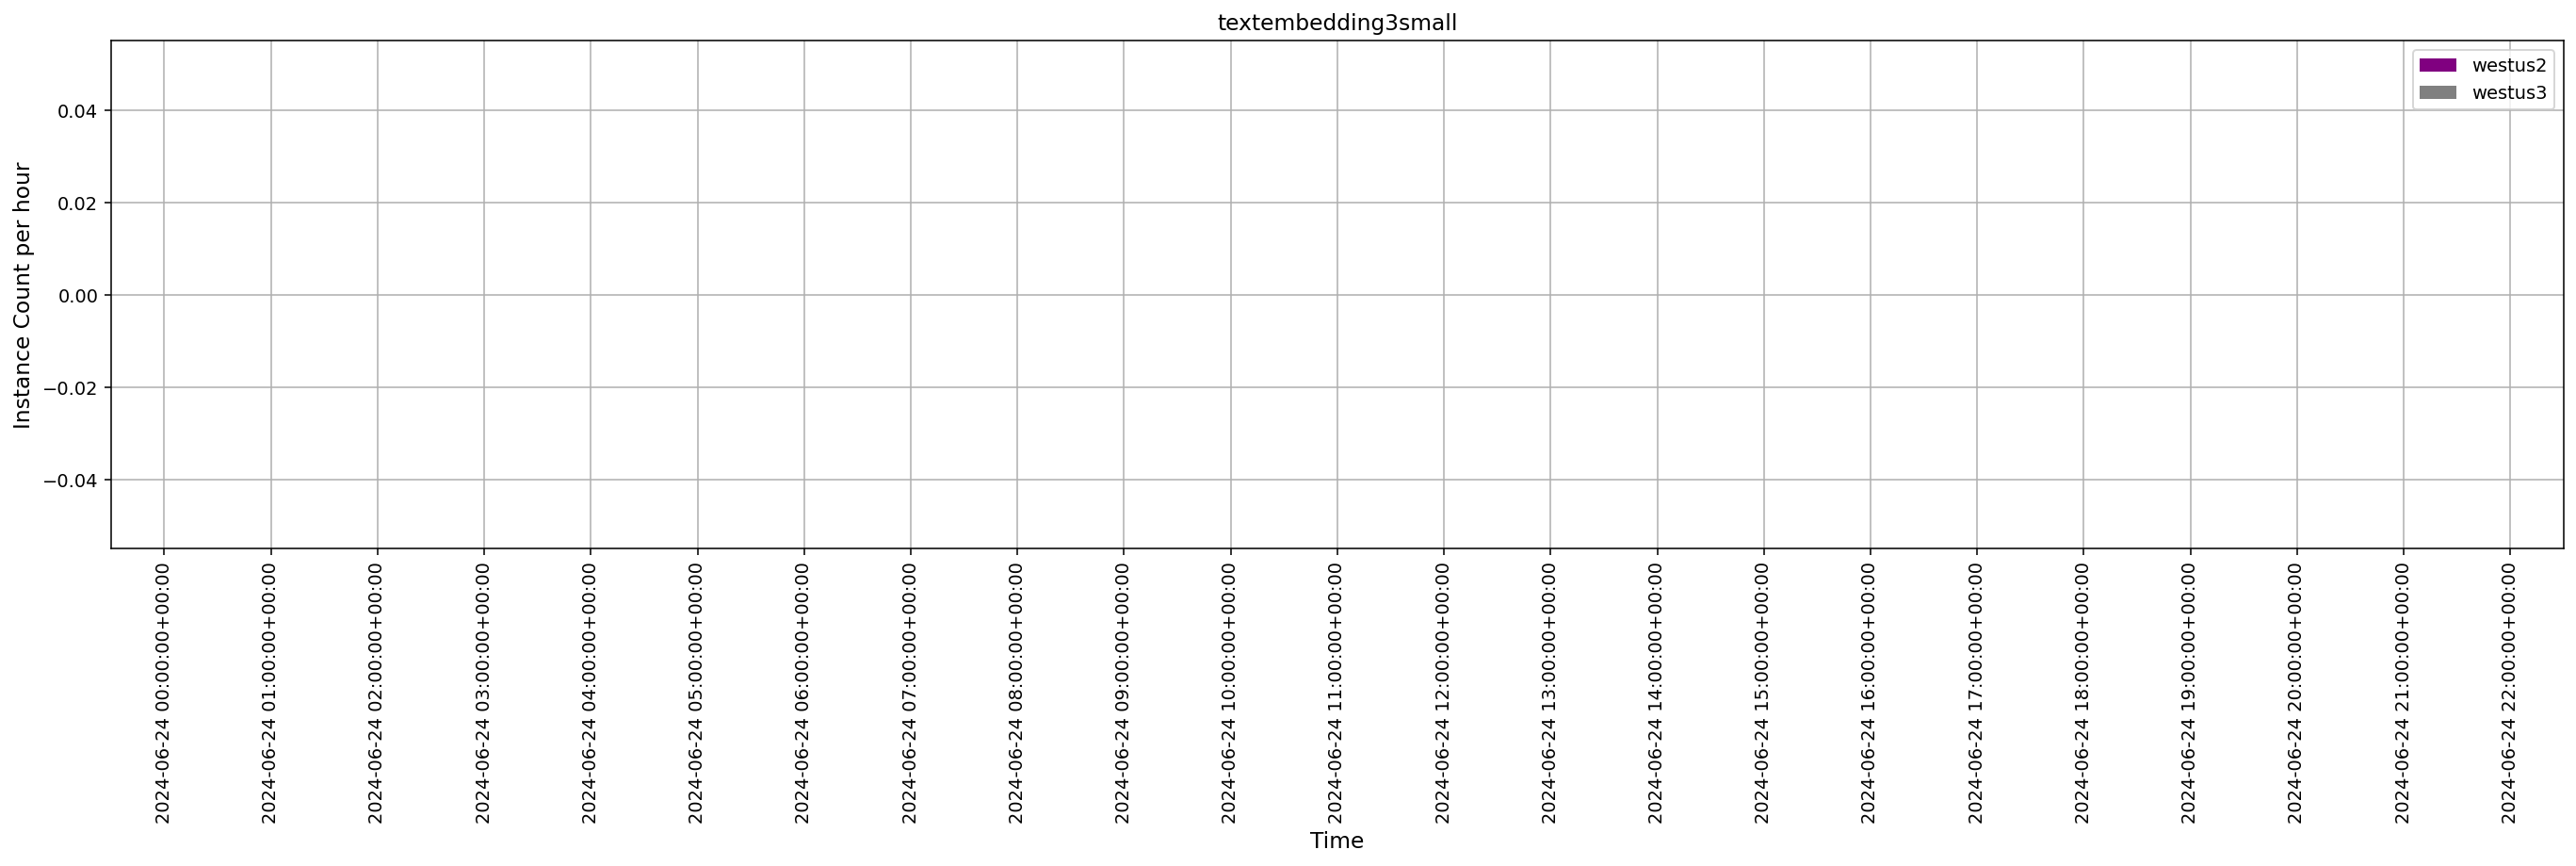

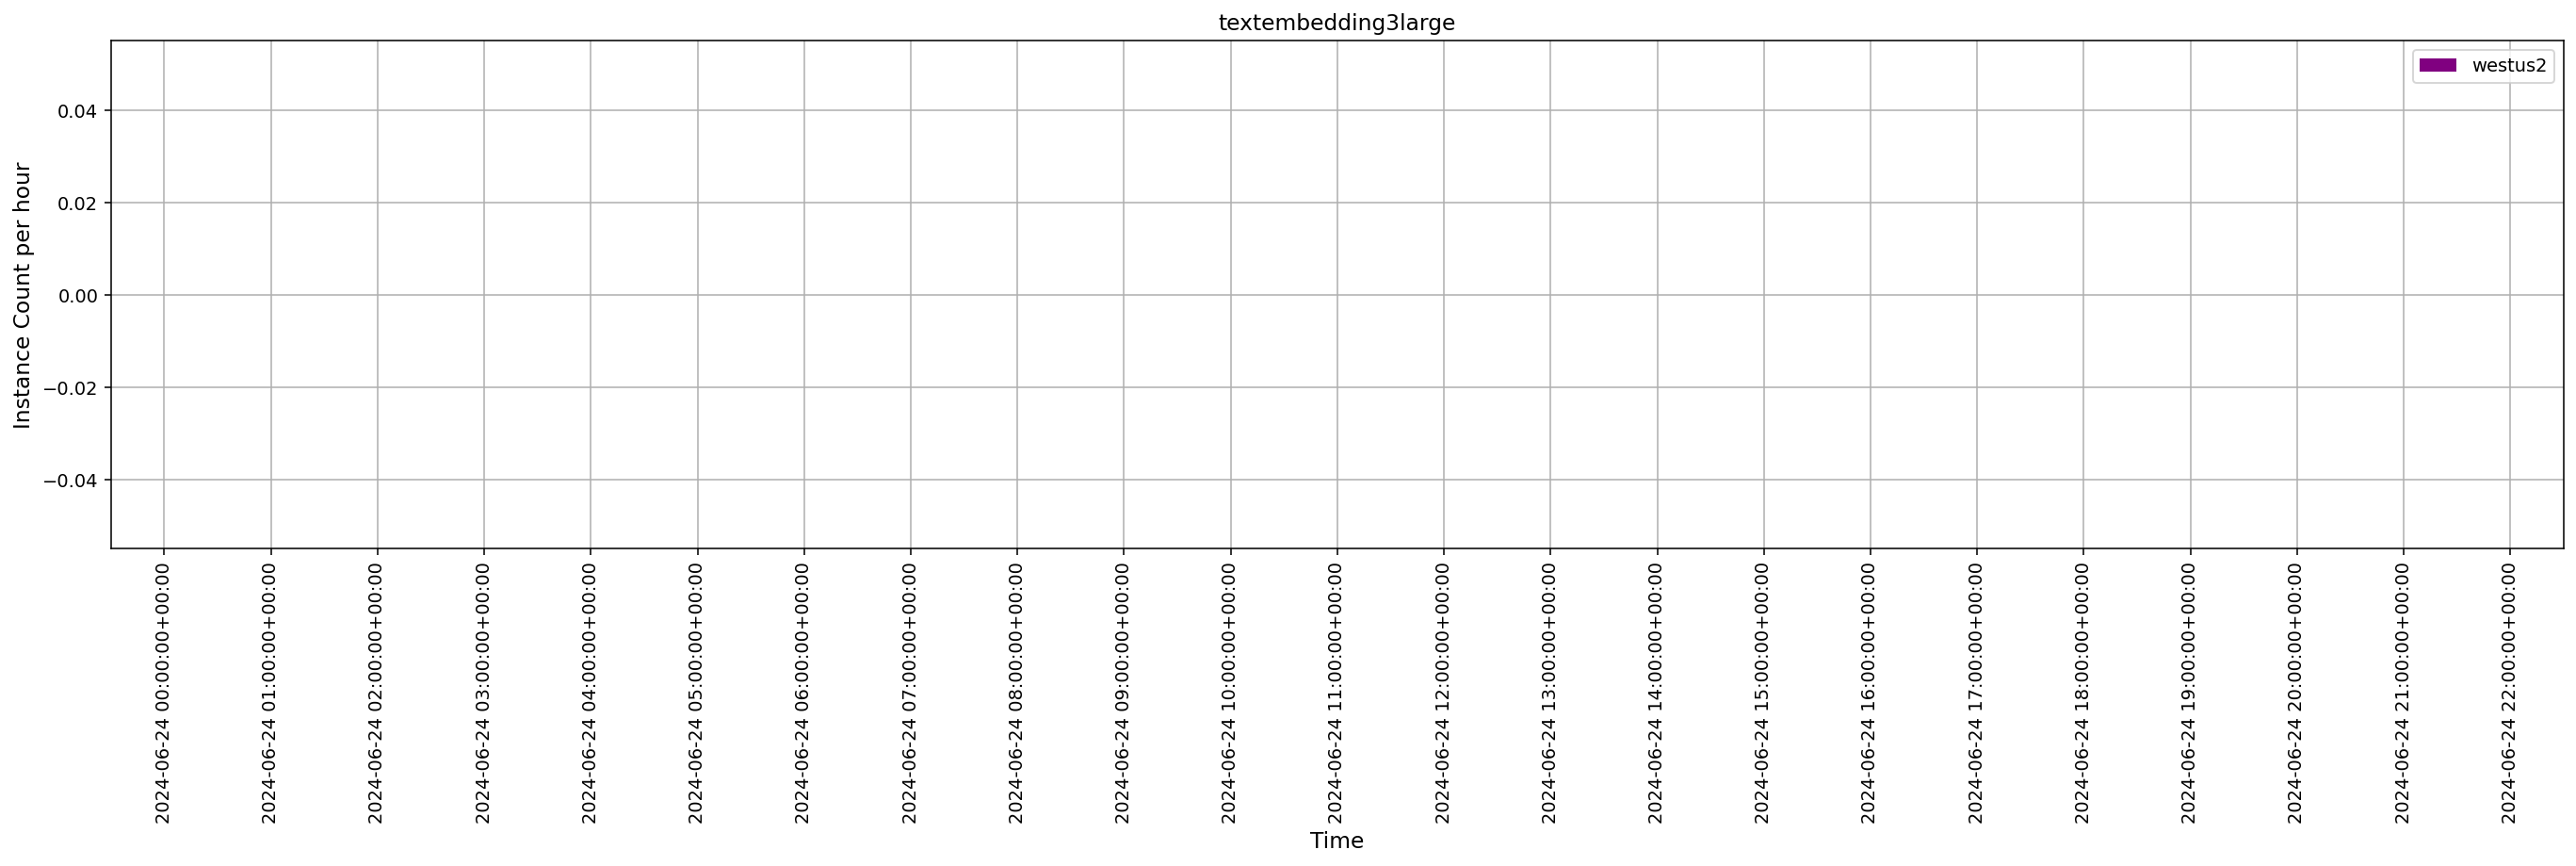

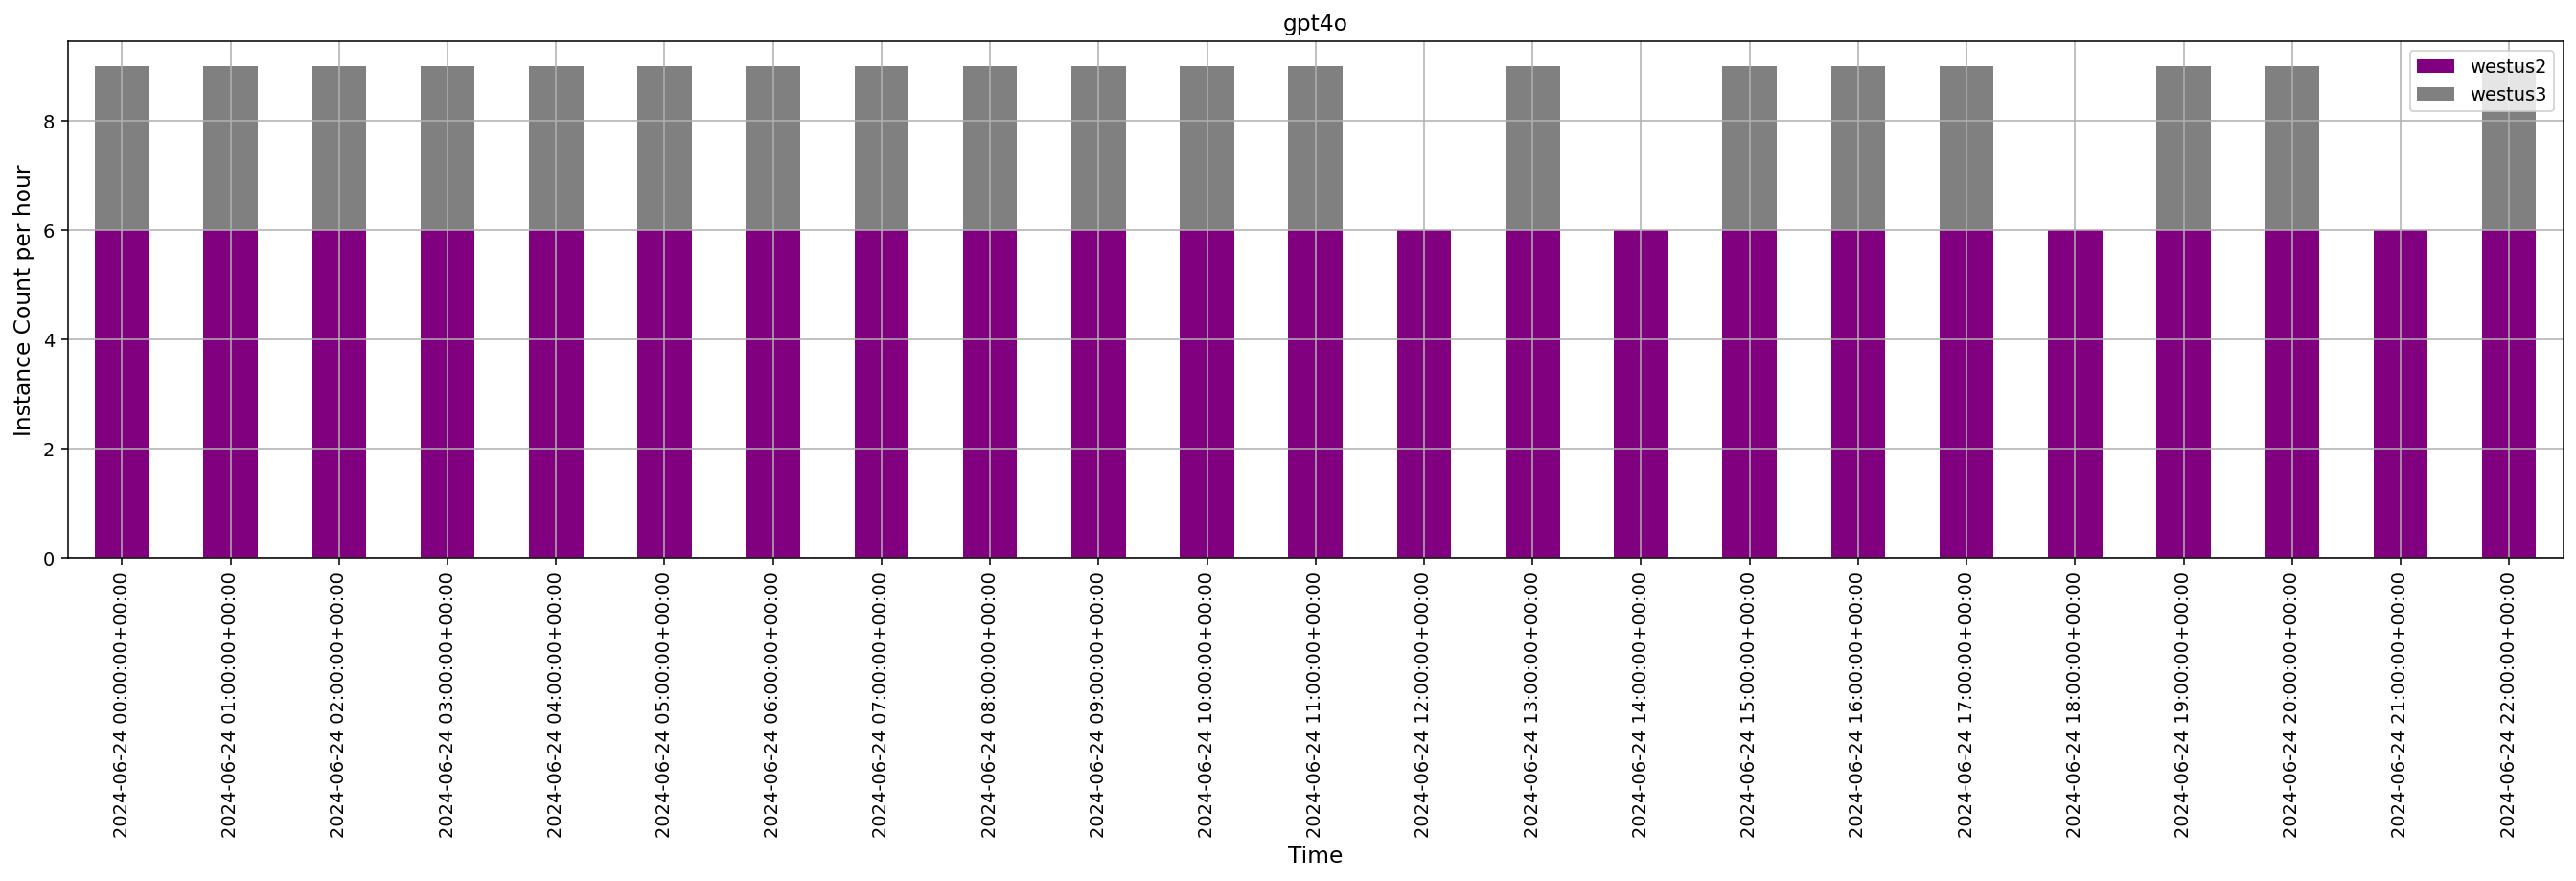

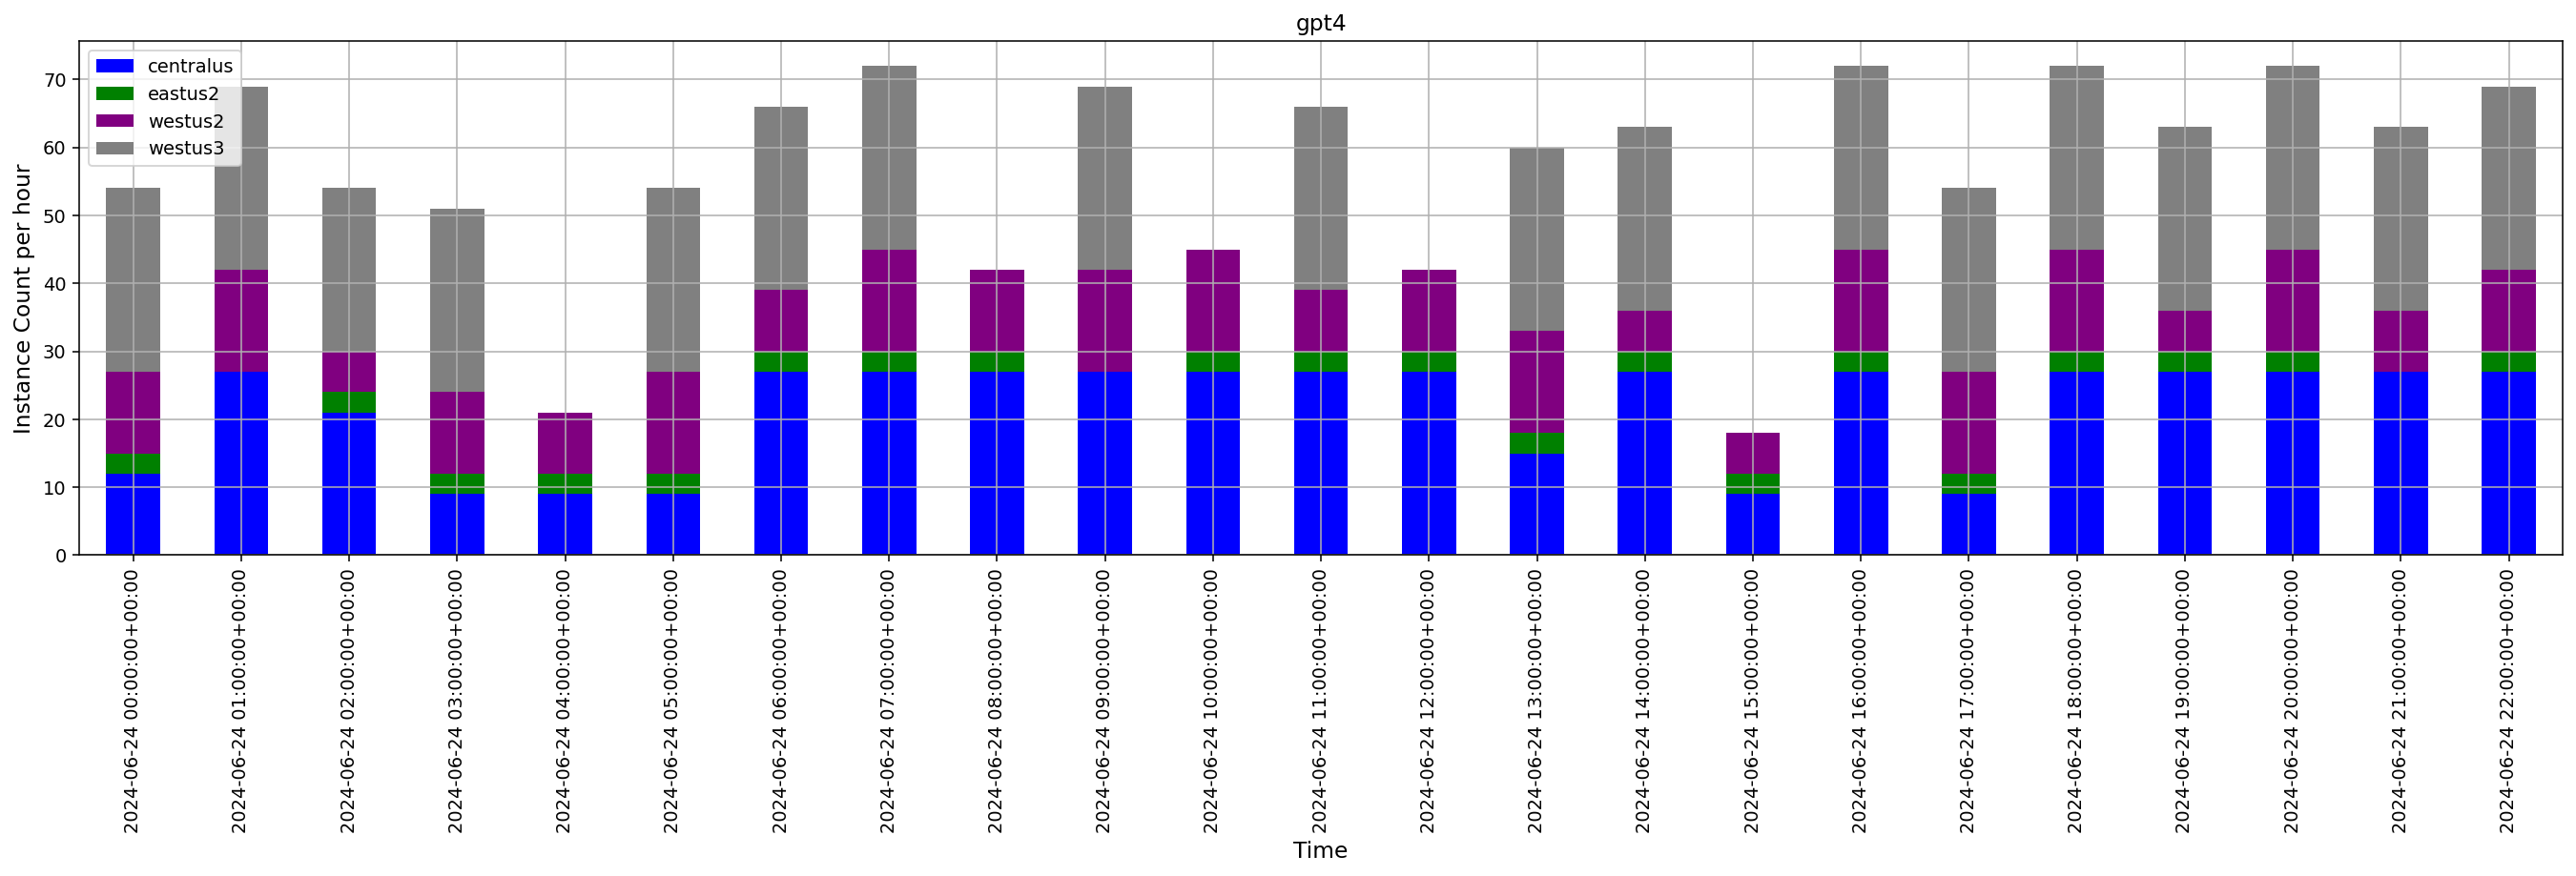

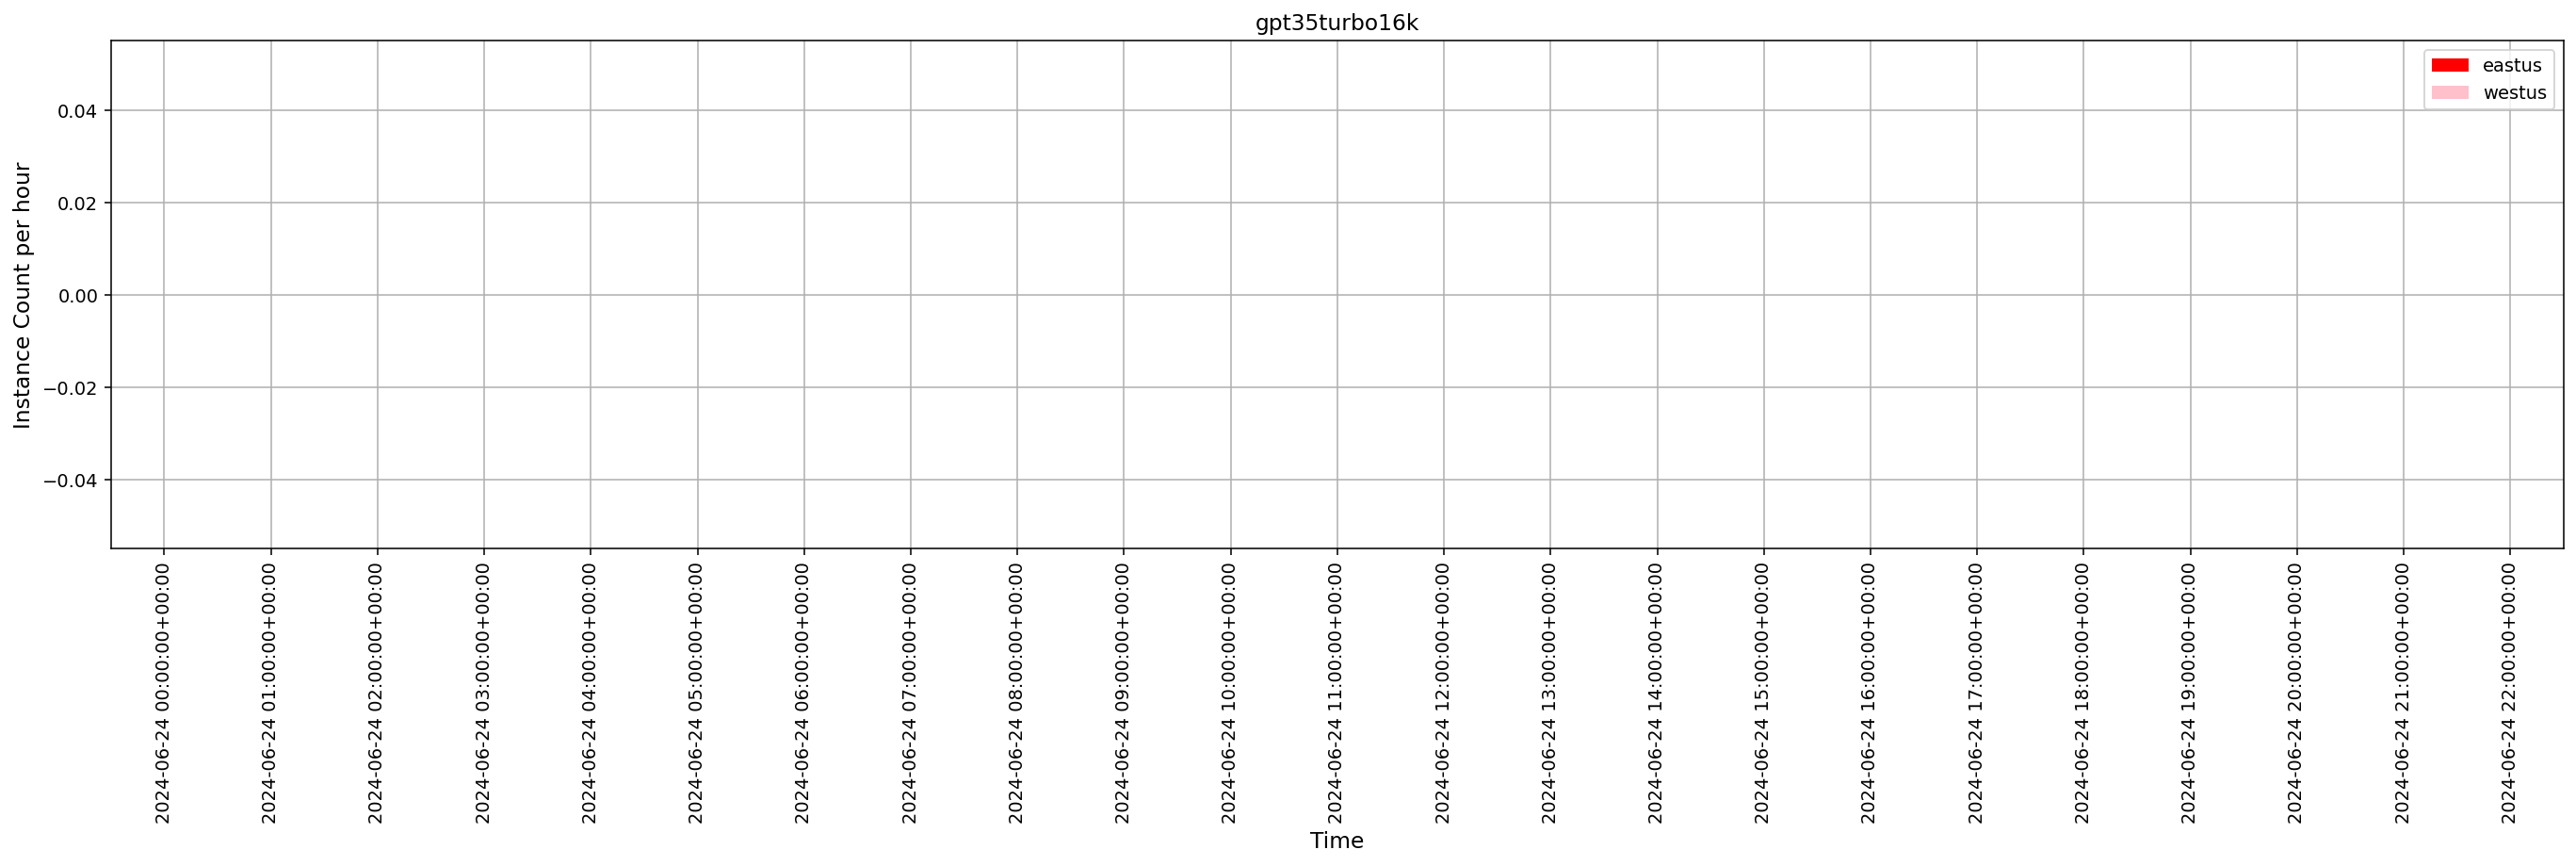

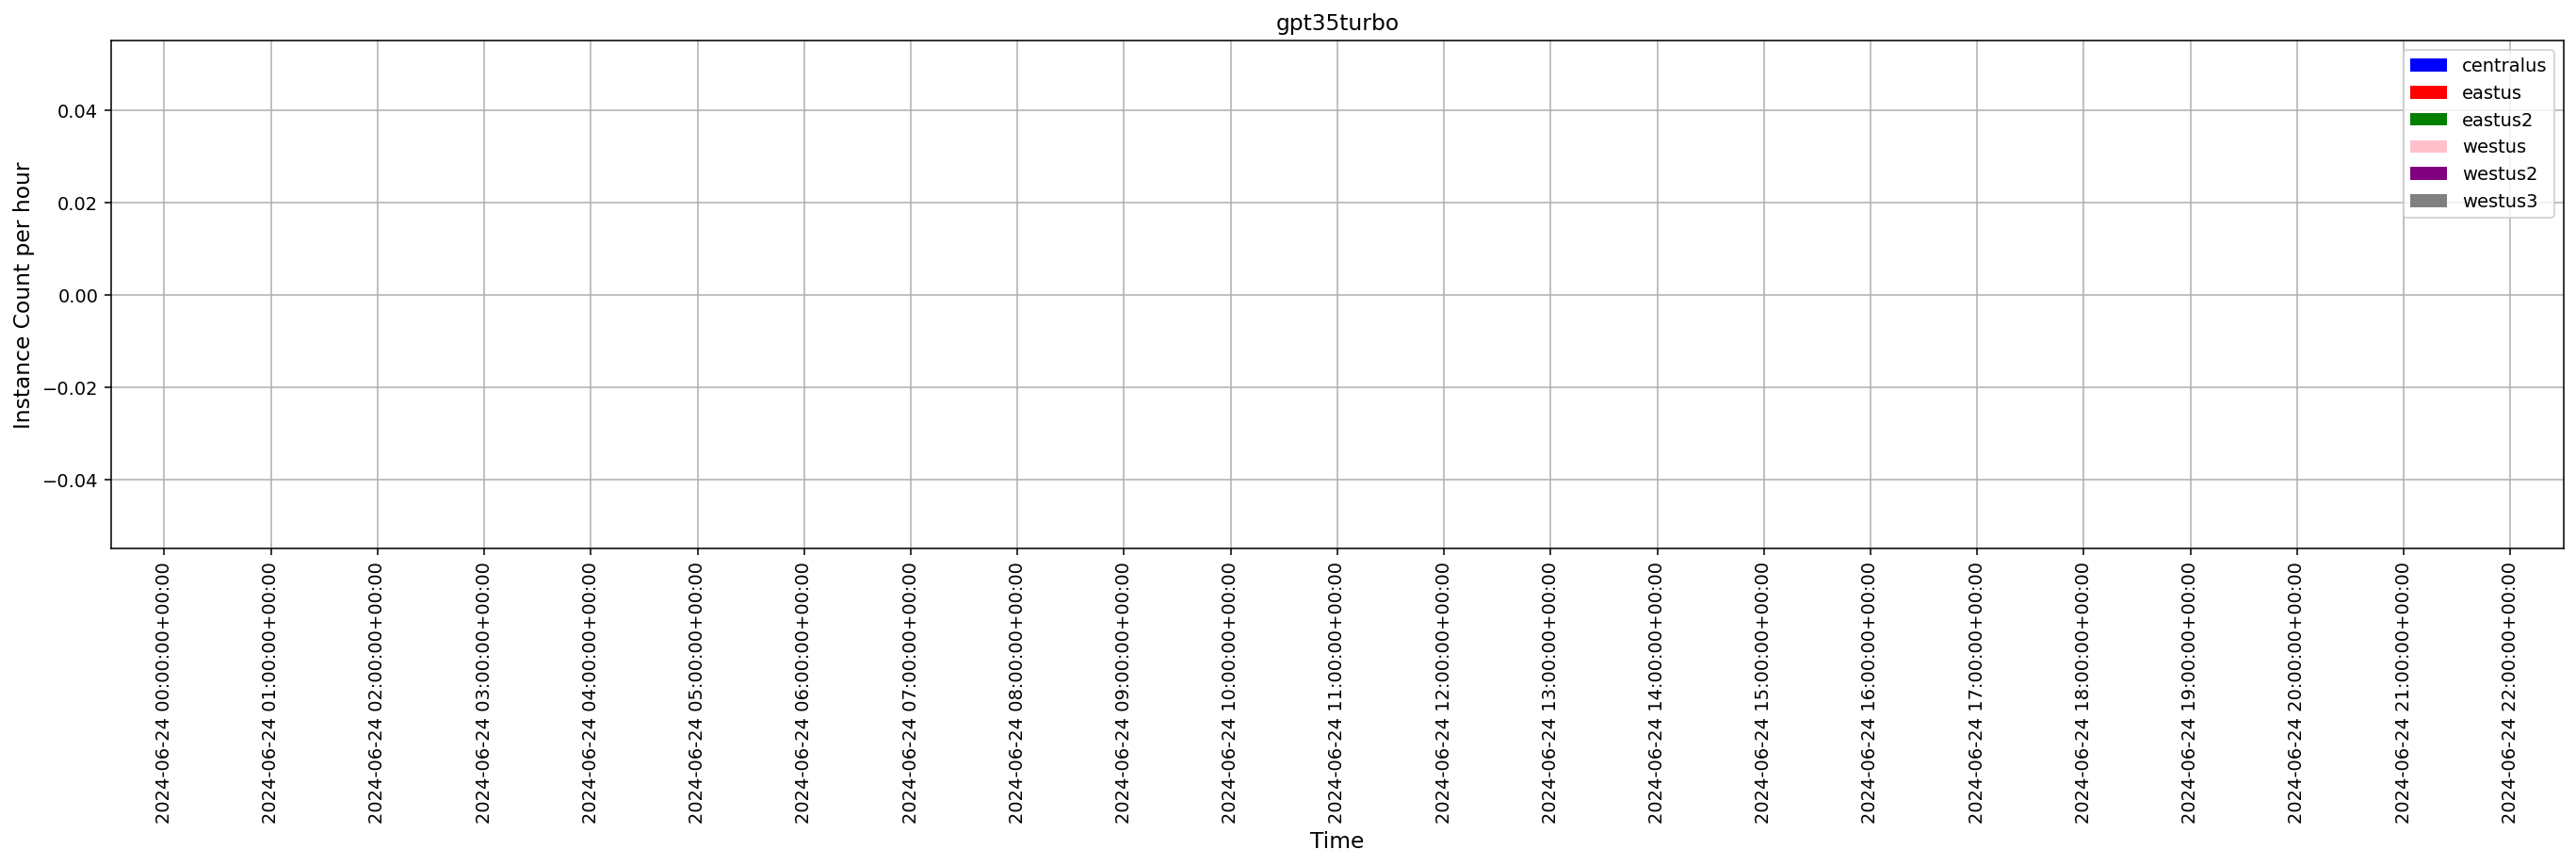

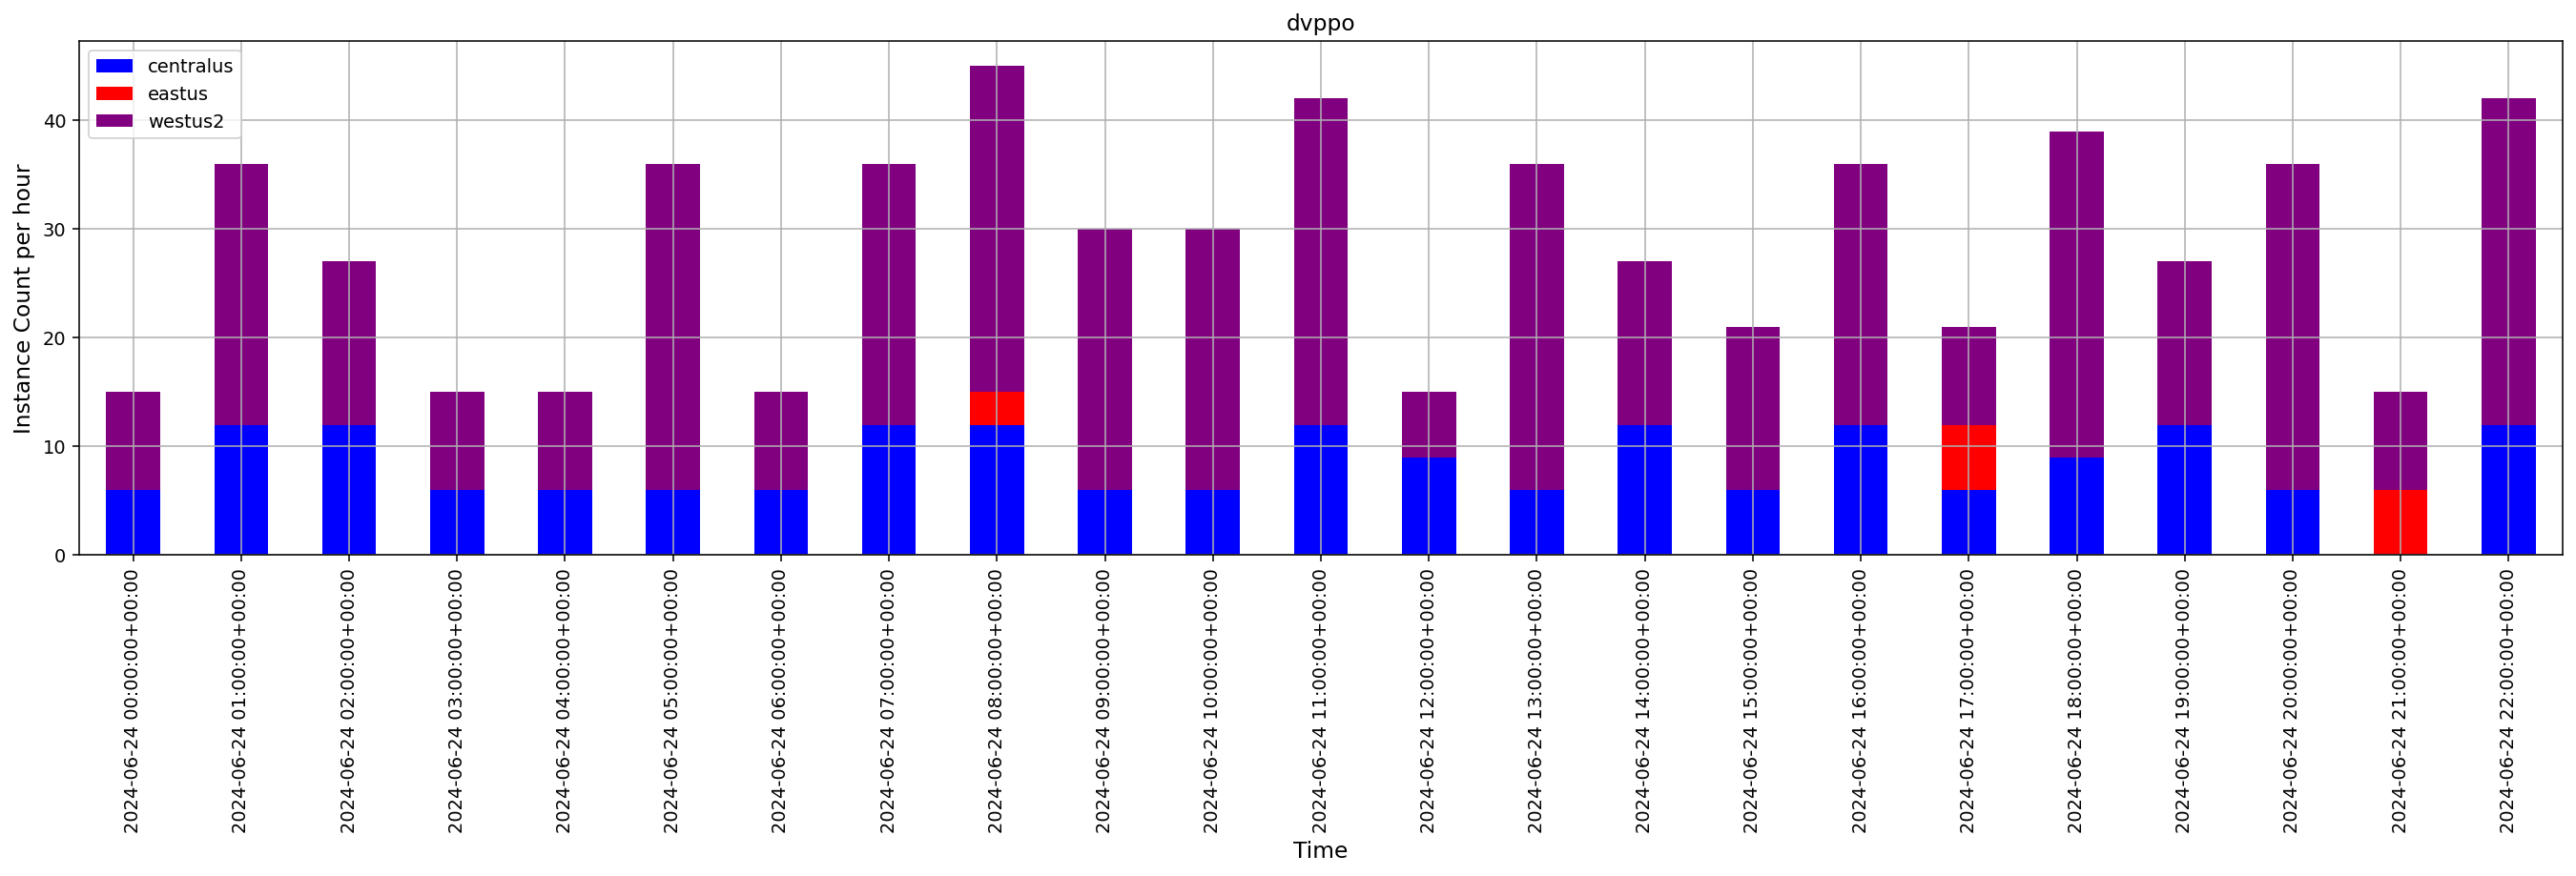

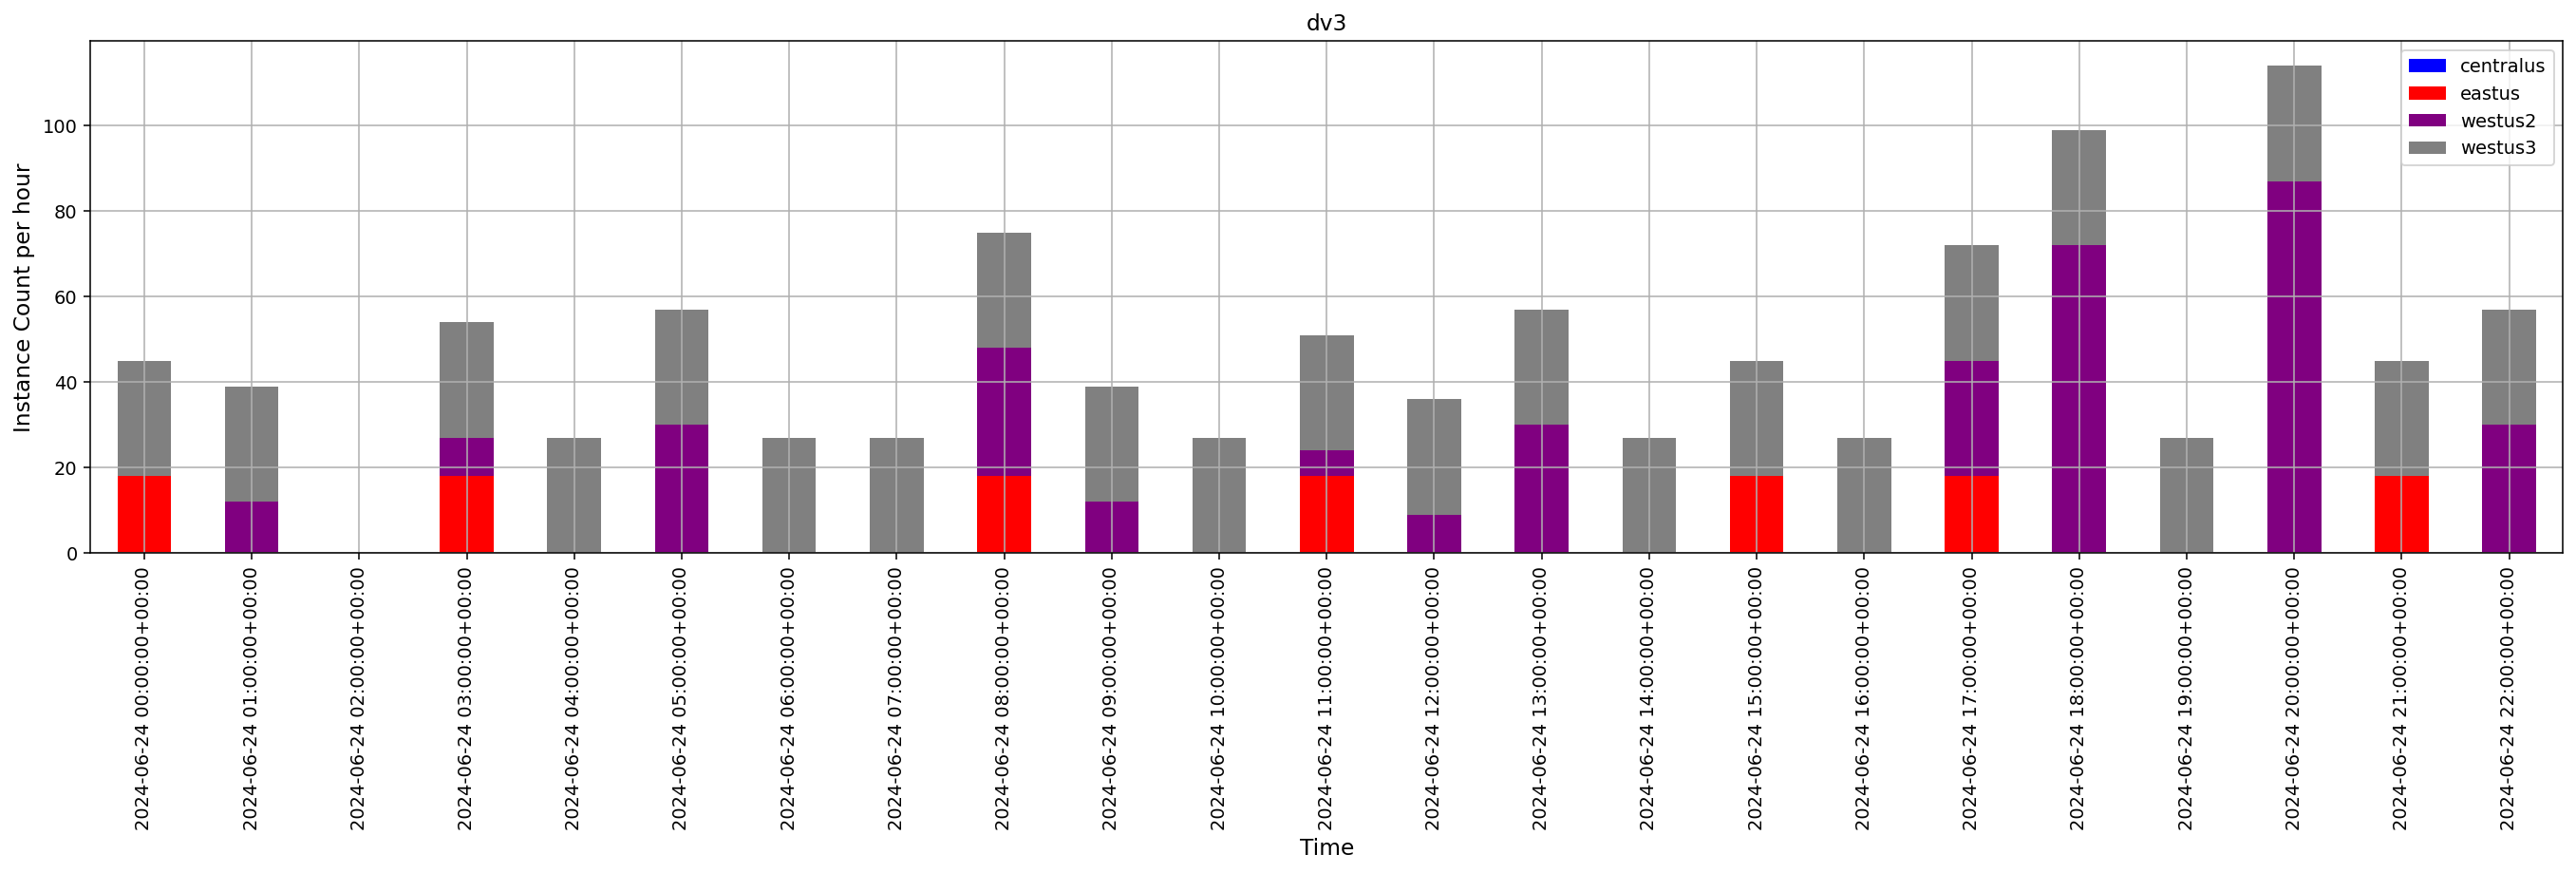

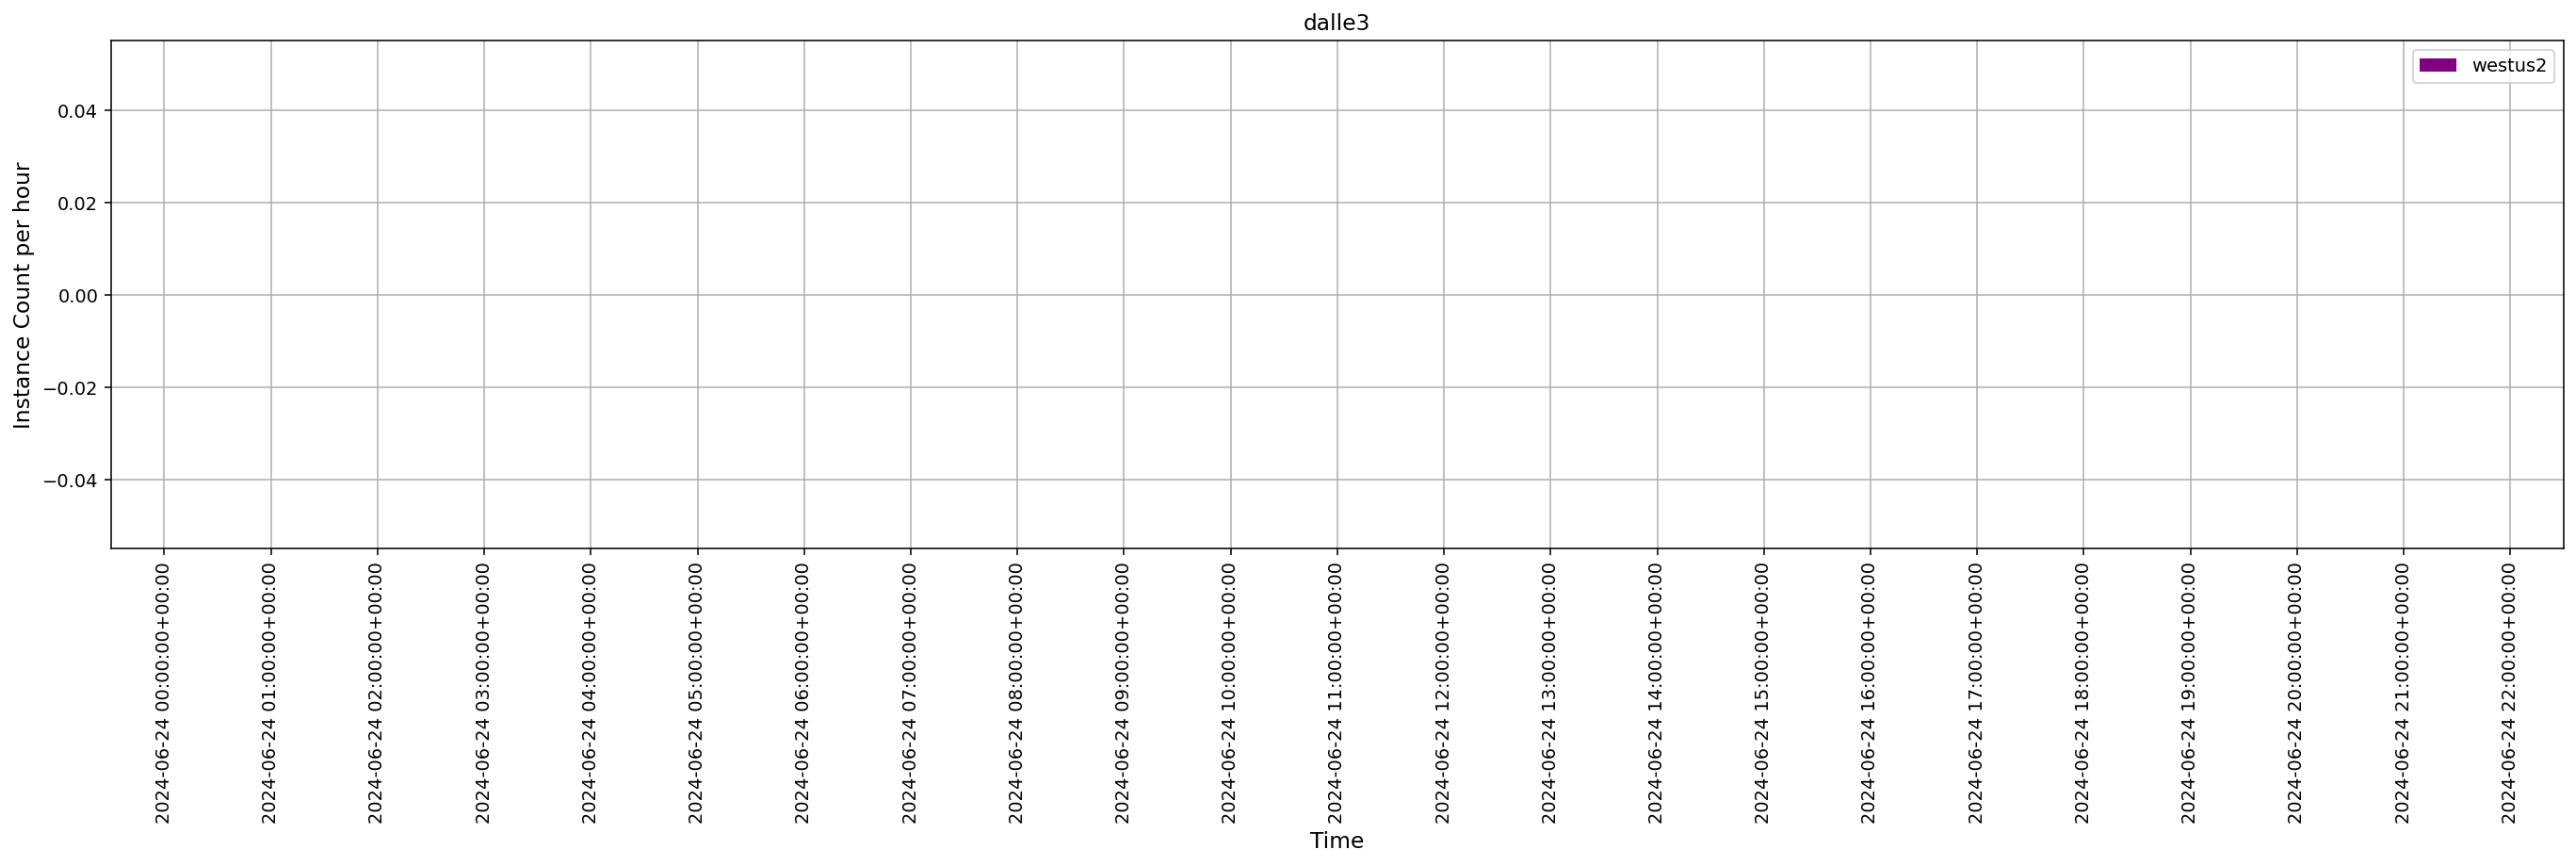

In [23]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 140
region_to_colors = {
    'centralus': 'blue',
    'eastus': 'red',
    'eastus2': 'green',
    'northcentralus': 'orange',
    'westus': 'pink',
    'westus2': 'purple',
    'westus3': 'grey'
}
for model_name in ['textembedding3small', 'textembedding3large', 'gpt4o', 'gpt4',
       'gpt35turbo16k', 'gpt35turbo', 'dvppo', 'dv3', 'dalle3']:
    filtered_df = dfa[dfa['Model'] == model_name]
    # Group the dataframe by TIMESTAMP and DeploymentRegion and sum the requestsCount
    grouped_df = filtered_df.groupby(['TIMESTAMP', 'Location'])['DonatedInstanceCount'].sum().unstack()
    # print(res.groupby(['TIMESTAMP', 'DeploymentRegion'])['requestsCount'].sum().unstack())
    # plt.figure(figsize=(10, 5), dpi=150)
    # Plot the stacked barplot
    grouped_df = grouped_df.fillna(0)
    grouped_df.plot(kind='bar', stacked=True, figsize=(24, 5), color=[region_to_colors.get(region) for region in grouped_df.columns])
    # grouped_df.plot(kind='bar', stacked=True, figsize=(24, 5))

    # Set the x-axis label
    plt.xlabel('Time', fontsize=12)
    plt.title(f"{model_name}")
    # Set the y-axis label
    plt.ylabel('Instance Count per hour', fontsize=12)

    # Show the legend
    plt.legend()
    plt.grid()
    # Show the plot
    plt.show()